# Colocalization between placental mQTL, psychiatric and developmental traits

Idea: for all heritable CpGs, test for colocalization between traits and GWAS summary statistics for conditions where a significant proportion of heritability can be explained by placental mQTL.
Traits to include:
* Neuropsychiatric
    1. OCD
    1. TS
    1. ADHD
    1. ASD
    1. MDD
    1. BIP
    1. AN
    1. SCZ
* Developmental: 
    1. Pubertal Growth Start
    1. Asthma
    1. Child BMI
    1. Child Onset Asthma

In [1]:
library(tidyverse)
library(data.table)
library(coloc)
library(bigsnpr)
library(here)
library(parallel)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is a new update to coloc.

Loading required package: bigstatsr

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
if (file.exists(here("data","marginal_mcpg_bonf.txt.gz"))){
    marginal_bonf <- fread(here("data","marginal_mcpg_bonf.txt.gz"),key="SNP")
}else{
    marginal <- fread(here("data","delahaye_richs_marginal_mecs_maf01.txt.gz"))
    marginal_bonf <- fread(here("data","delahaye_richs_marginal_bonf_maf05.txt.gz"))[Chr != 23]
    marginal_bonf <- marginal[Probe %in%marginal_bonf$Probe]
    fwrite(marginal_bonf,here("data","marginal_mcpg_bonf.txt.gz"),row.names=F,quote=F,sep='\t')
}

In [15]:
rds < -snp_readBed2(
    "/arc/project/st-dennisjk-1/shared/data/1000G_EUR_ldsc_data/1000G_EUR_Phase3_plink/1000G.EUR.QC.ALL.bed",
    backingfile=tempfile(),
)

reference < -snp_attach(rds)

str(reference)

List of 3
 $ genotypes:Reference class 'FBM.code256' [package "bigstatsr"] with 16 fields
  ..$ extptr      :<externalptr> 
  ..$ extptr_rw   :<externalptr> 
  ..$ nrow        : int 489
  ..$ ncol        : int 9997231
  ..$ type        : Named int 1
  .. ..- attr(*, "names")= chr "unsigned char"
  ..$ backingfile : chr "/tmp/pbs.4762533.pbsha.ib.sockeye/RtmpWugxi1/file184ef22d6f4dc.bk"
  ..$ is_read_only: logi FALSE
  ..$ address     :<externalptr> 
  ..$ address_rw  :<externalptr> 
  ..$ bk          : chr "/tmp/pbs.4762533.pbsha.ib.sockeye/RtmpWugxi1/file184ef22d6f4dc.bk"
  ..$ rds         : chr "/tmp/pbs.4762533.pbsha.ib.sockeye/RtmpWugxi1/file184ef22d6f4dc.rds"
  ..$ is_saved    : logi TRUE
  ..$ type_chr    : chr "unsigned char"
  ..$ type_size   : int 1
  ..$ file_size   : num 4.89e+09
  ..$ code256     : num [1:256] 0 1 2 NA NA NA NA NA NA NA ...
  ..and 26 methods, of which 12 are  possibly relevant:
  ..  add_columns,
  ..  as.FBM,
  ..  bm,
  ..  bm.desc,
  ..  check_dimension

In [39]:
compute_coloc <- function(SNP,mqtl,gwas,method="coloc", type="quant",s=NULL){# SNP must be in SNP column of mqtl and gwas
    D1 <- list(
            beta = mqtl$b,
            varbeta = mqtl$SE^2,
            snp = mqtl$SNP,
            position = mqtl$BP,
            N = 400,
            MAF = mqtl$Freq,
            type="quant"
        )
    D2 <- list(
            pvalues = pnorm(-abs(gwas$Z))*2,
            z=gwas$Z,
            snp = gwas$SNP,
            MAF = snp_MAF(reference$genotypes,ind.col = match(gwas$SNP,reference$map$marker.ID)),
            N = min(gwas$N),
            type=type,
            s = s
        )
    if(method == "susie"){
        LD <- snp_cor(reference$genotypes,ind.col = match(SNP, reference$map$marker.ID))^2
        LD <- as.matrix(LD)
        colnames(LD) <- SNP
        rownames(LD) <- SNP
        D1$LD <- LD
        D2$LD <- LD
        S1 <- runsusie(D1)
        S2 <- runsusie(D2)
        return(coloc.susie(S1,S2))
    }else if(method == "coloc"){
        return(coloc.abf(D1,D2))
    }else{
        return(NULL)
    }
}

In [14]:
gwas <- fread("../../tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",key="SNP")

tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]

eligible_cpg <- unlist(mclapply(
    unique(tmp_marginal_bonf$Probe),
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
        return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
    },
    mc.cores=16
))
test <- mclapply(
    unique(marginal_bonf$Probe)[eligible_cpg],
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[SNP %in% mqtl$SNP]
        res <- suppressMessages(compute_coloc(mqtl$SNP,mqtl,gwas_tmp,method="coloc",s=0.36,type="cc")$summary)
        return(res)
    },
    mc.cores=16
)

names(test) <- unique(marginal_bonf$Probe)[eligible_cpg]
result_adhd <- rbindlist(lapply(test,function(x)data.table(t(x))))
result_adhd

# Repeating above for all psychiatric GWAS

In [3]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.fs.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.cc.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgcAN2.2019-07_refmt.vcf.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/iPSYCH-PGC_ASD_Nov2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/ocd_aug2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_alcdep.eur_unrelated.aug2018_release_refmt.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_bip_2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/MDD2018_ex23andMe.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC3_SCZ_wave3_public.v2.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/tag.cpd.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/TS_Oct2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pts_all_freeze2_overall.results.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    0.36,
    NULL,
    0.33,
    0.23,
    NULL,
    0.30,
    0.40,
    0.28,
    0.26,
    0.15,
    0.34,
    0.35,
    0.42,
    NULL,
    0.34,
    0.15,
)

ERROR: Error in eval(expr, envir, enclos): object 'sumstat_files' not found


In [ ]:
result <- list()
for( i in 1:length(sumstat_files)){
    gwas <- fread(sumstat_files[i])
    tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]
    eligible_cpg <- unlist(mclapply(
        unique(tmp_marginal_bonf$Probe),
        function(probe){
            mqtl <- tmp_marginal_bonf[Probe == probe]
            gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
            return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
        },
        mc.cores=16
    ))
    if(sum(eligible_cpg) ){
        test <- mclapply(
            unique(tmp_marginal_bonf$Probe)[eligible_cpg],
            function(probe){
                mqtl <- tmp_marginal_bonf[Probe == probe]
                gwas_tmp <- gwas[SNP %in% mqtl$SNP]
                res <- suppressMessages(
                    compute_coloc(
                        mqtl$SNP,
                        mqtl,
                        gwas_tmp,
                        method="coloc",
                        s=sample_prev[i],
                        type=ifelse(is.null(sample_prev[i]),"quant","cc")
                    )$summary
                )
                return(res)
            },
            mc.cores=16
        )
        names(test) <- unique(tmp_marginal_bonf$Probe)[eligible_cpg]
        res <- rbindlist(lapply(test,function(x)data.table(t(x))))
        result[[trait_names[i]]] <- res
    }
}

In [64]:
str(result)

 list()


# Neonatal Traits

In [ ]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PGF_PGM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_Obesity_Meta_Analysis_1.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG-TotalGWG-Offspring.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PTF_PTM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_BMI_HapMap_DISCOVERY.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_10F_12M_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_HC_DISCOVERY.v2.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 0.0296
)

# Summary of all trait colocalization

In [2]:
template <- ".*/(.*)_(cross-sex|male_mqtl|female_mqtl)colocalization.txt"
sex_trait_coloc <- dir(here("data"),pattern= ".*colocalization.txt",full.names = TRUE)
sex_stratified_coloc <- lapply(
    sex_trait_coloc,
    function(f){
        df<-fread(f)
        df$mQTL <- gsub(template,"\\2",f)
        return(df)
    }
)
names(sex_stratified_coloc) <- gsub(template,"\\1",sex_trait_coloc)
sex_coloc_table <- rbindlist(sex_stratified_coloc,idcol="GWAS")

In [3]:
head(sex_coloc_table)

GWAS,probe,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,mQTL
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
10F_12M,cg02936049,66,7.230616e-33,3.080769e-06,8.741129e-29,0.03627985,0.9637171,cross-sex
10F_12M,cg13787933,26,2.540375e-06,2.104101e-03,7.963788e-04,0.65927411,0.3378229,cross-sex
10F_12M,cg00106432,95,4.702146e-14,5.522329e-05,3.240539e-11,0.03709493,0.9628498,cross-sex
10F_12M,cg14598478,39,1.860955e-06,2.625608e-05,1.680221e-03,0.02273055,0.9755611,female_mqtl
10F_12M,cg02936049,42,1.278513e-12,3.080399e-06,1.545564e-08,0.03627451,0.9637224,female_mqtl
10F_12M,cg00106432,74,3.291216e-09,5.488256e-05,2.250627e-06,0.03656688,0.9633760,female_mqtl


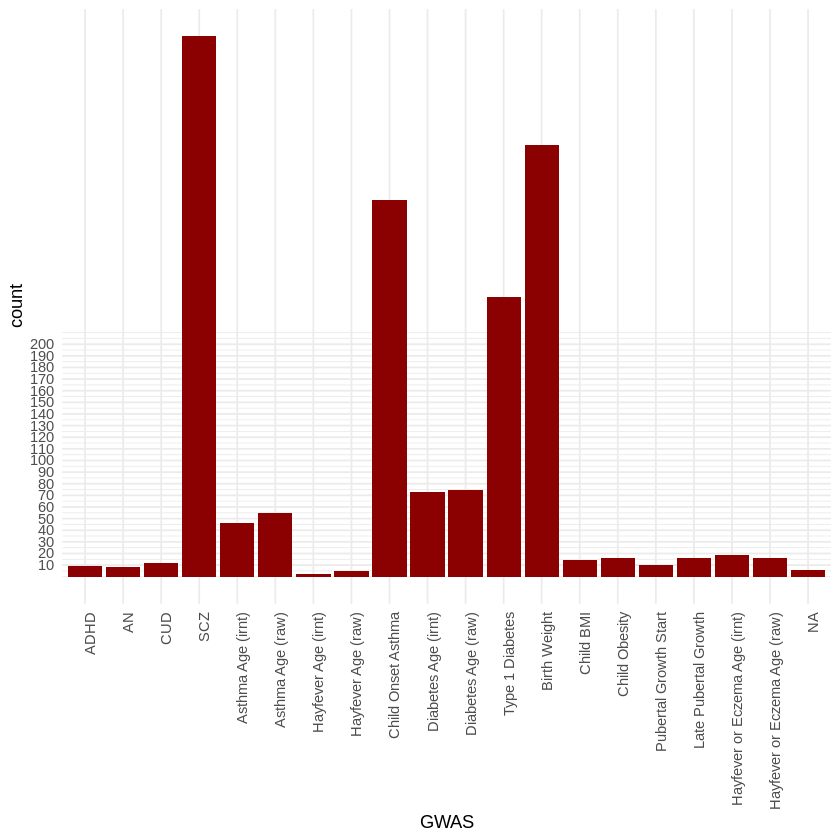

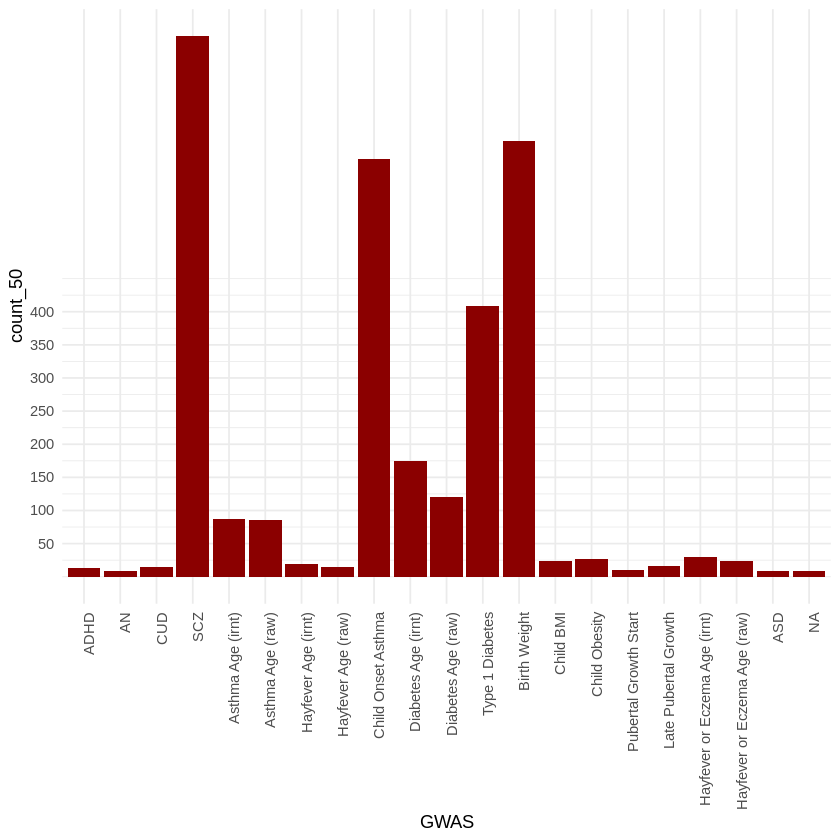

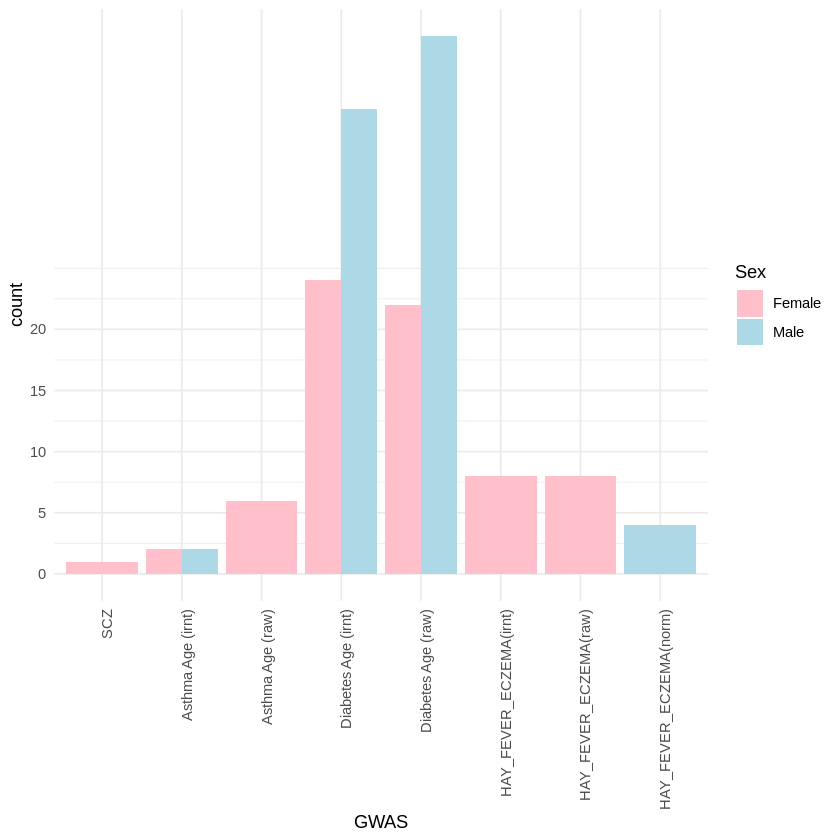

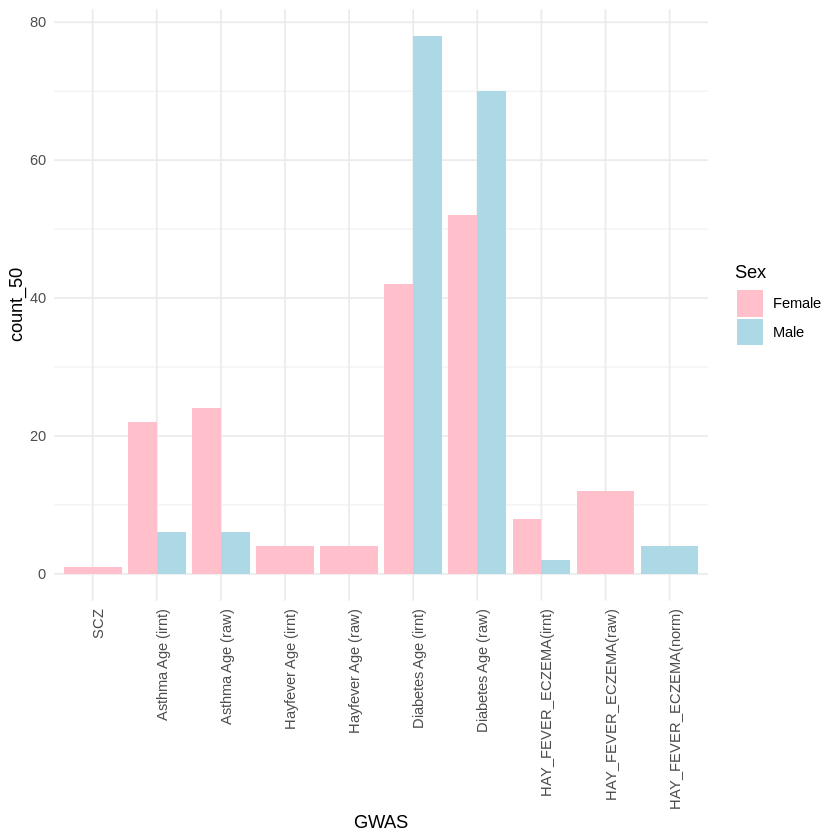

In [4]:
to_plot <- sex_coloc_table[
    !grepl("MALE|BIP|ANX|MDD|TAG_CPD|AUDIT",GWAS),
    .(
        proportion = sum(PP.H4.abf > 0.9) / .N,
        count=sum(PP.H4.abf > 0.9),
        count_50 =sum(PP.H4.abf > 0.5)
    ),by=GWAS]
to_plot$GWAS <- recode_factor(
    to_plot$GWAS,
    "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "CHILD_ASTHMA" = "Child Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Child BMI",
    "EGG_OBESITY" = "Child Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth",
    "HAY_FEVER_ECZEMA(irnt)" = "Hayfever or Eczema Age (irnt)",
    "HAY_FEVER_ECZEMA(raw)" = "Hayfever or Eczema Age (raw)")

ggplot(
    to_plot[count != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count)
) +
geom_col(fill="dark red") +
scale_y_continuous(breaks=1:20 * 10)+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

ggplot(
    to_plot[count_50 != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count_50)
) +
geom_col(fill="dark red") +
scale_y_continuous(breaks=1:8 * 50)+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

to_plot <- sex_coloc_table[
        grepl("MALE",GWAS),
        .(
            proportion = sum(PP.H4.abf > 0.9) / .N,
            count=sum(PP.H4.abf >0.9),
            count_50 = sum(PP.H4.abf >0.5)
        ),
        by=GWAS
    ]
to_plot <- to_plot[!grepl("BIP|ANX|MDD|TAG_CPD|AUDIT",GWAS),.(
        count,
        count_50,
        proportion,
        GWAS = gsub("_MALE|_FEMALE","",GWAS),
        Sex=ifelse(grepl("FEMALE",GWAS),"Female","Male")
    )
]
to_plot$GWAS <- recode_factor(
    to_plot$GWAS,
     "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "CHILD_ASTHMA" = "Child Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Child BMI",
    "EGG_OBESITY" = "Child Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth")
ggplot(
   to_plot[count != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("pink","light blue"))+
scale_y_continuous(breaks=seq(0,20,5))+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

ggplot(
   to_plot[count_50 != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count_50,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("pink","light blue"))+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

### Quick follow up experiments
1. Plot number of colocalized CpGs as function of trait heritability
2. Plot number of colocalized CpGs as a function of proportion of heritability explained by placental mQTL
3. Plot number of genes corresponding to colocalized CpGs

In [5]:
# load in heritability results
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results_independent <- function(path){
    part_heritability <- rbindlist(lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female]_bin_CPP_her_.*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(bin_CPP_her)_(.*).results$")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        ))
    log_files <- dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE
    )
    log_files <-log_files[!grepl("_shared",log_files)]
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE,
        
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*).log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[3] & annotation == labels[2]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[2],
            GWAS = labels[3]
          )
          return(dt)
        }
      }
    ))
    heritability <- heritability[which(!duplicated(GWAS))]
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}

part_heritability_results <- function(path,modifier){
    part_heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.results$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*){modifier}.results"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else {
          dt <- fread(f)
          dt[, 
            `:=`(
              Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
              annotation = labels[1],
              GWAS = labels[2])]
          return(dt)
        }
      }
    ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(bin_CPP_her)_(.*){modifier}.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}
annotation_SD <- function(path,file_pattern){
    annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
    return(apply(annots[,-c(1,2,3,4)],2,sd))    
}
pgc_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/")
neonatal_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/")

                                 
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "meta_STDERR_rmdd_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "RMDD Males",
    "meta_STDERR_rmdd_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "RMDD Females",
    "ocd_aug2017" = "OCD",
    "OCD_meta_male_auto_072416.gz" = "OCD Males",
    "OCD_meta_female_auto_072416.gz" = "OCD Females",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "ukbb_anxiety.gwas.imputed_v3.both_sexes.tsv.gz.fixed" = "UKBB-ANX",
    "ukbb_anxiety.gwas.imputed_v3.male.tsv.gz.fixed" = "UKBB-ANX Males",
    "ukbb_anxiety.gwas.imputed_v3.female.tsv.gz.fixed" = "UKBB-ANX Females",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "meta_STDERR_bip_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "BIP Males",
    "meta_STDERR_bip_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "BIP Females",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "meta_STDERR_scz_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "SCZ Males",
    "meta_STDERR_scz_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "SCZ Females",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
neonatal_GWAS_key <- c(
    "age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(norm)",
    "age_asthma_irnt.gwas.imputed_v3.female.tsv" = "ASTHMA Age(norm) Females",
    "age_asthma_irnt.gwas.imputed_v3.male.tsv"= "ASTHMA Age(norm) Males",
    "age_asthma_raw.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(raw)",
    "age_asthma_raw.gwas.imputed_v3.female.tsv" = "ASTHMA Age(raw) Females",
    "age_asthma_raw.gwas.imputed_v3.male.tsv" = "ASTHMA Age(raw) Males",
    "age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_DIABETES(norm)",
    "age_diabetes_irnt.gwas.imputed_v3.female.tsv"= "DIABETES Age(norm) Females",
    "age_diabetes_irnt.gwas.imputed_v3.male.tsv"= "DIABETES Age(norm) Males",
    "age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv"= "AGE_DIABETES(raw)",
    "age_diabetes_raw.gwas.imputed_v3.female.tsv"= "DIABETES Age(raw) Females",
    "age_diabetes_raw.gwas.imputed_v3.male.tsv"= "DIABETES Age(raw) Males",
    "age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(norm)",
    "age_hay_fever_irnt.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(norm) Females",
    "age_hay_fever_irnt.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(norm) Males",
    "age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(raw)",
    "age_hay_fever_raw.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(raw) Females",
    "age_hay_fever_raw.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(raw) Males",
    "CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC" = "CHILD_ASTHMA",
    "hayfever_eczema_raw.gwas.imputed_v3.both_sexes.tsv" = "Hayfever or Eczema Age(raw)",
    "hayfever_eczema_raw.gwas.imputed_v3.female.tsv" = "Hayfever or Eczema Age(raw) Females",
    "hayfever_eczema_raw.gwas.imputed_v3.male.tsv" = "Hayfever or Eczema Age(raw) Males",
    "EGG_BMI_HapMap_DISCOVERY.txt" = "EGG_BMI",
    "EGG_HC_DISCOVERY.v2.txt" = "Head Circumference",
    "EGG_Obesity_Meta_Analysis_1.txt" = "EGG_OBESITY",
    "EGG_TANNER_females.v2.txt" = "TANNER Stage Females",
    "EGG_TANNER_males_and_females_combined.v2.txt" = "TANNER Stage",
    "EGG_TANNER_males.v2.txt" = "TANNER Stage Males",
    "EGG-TotalGWG-Offspring.txt" = "GWG",
    "Pubertal_growth_10F_12M_combined.txt" = "10F_12M",
    "Pubertal_growth_10F.txt" = "Pubertal Growth Start Females",
    "Pubertal_growth_12M.txt" = "Pubertal Growth Start Males",
    "Pubertal_growth_PGF_PGM_combined.txt" = "PGF_PGM",
    "Pubertal_growth_PGF.txt" = "Total Pubertal Growth Females",
    "Pubertal_growth_PGM.txt" = "Total Pubertal Growth Males",
    "Pubertal_growth_PTF_PTM_combined.txt" = "PTF_PTM",
    "Pubertal_growth_PTF.txt" = "Late Pubertal Growth Females",
    "Pubertal_growth_PTM.txt" = "Late Pubertal Growth Males",
    "ukbb_preeclampsia.gwas.imputed_v3.female.tsv"= "Pre-Eclampsia During Pregnancy"
)
                                                                 
                                 
neonatal_part_heritability_independent_df <- neonatal_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key)) %>% na.omit()
                                 
pgc_part_heritability_independent_df <- pgc_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))  %>% na.omit()
                                 

In [6]:
manifest <- fread("../../../450k_annotation.csv")  # Gene mapping

coloc_sex <- sex_coloc_table %>% 
    mutate(
    GWAS =  as.character(recode_factor(
    GWAS,
    "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "HAY_FEVER_ECZEMA(irnt)" = "Hayfever or Eczema Age (irnt)",
    "HAY_FEVER_ECZEMA(raw)" = "Hayfever or Eczema Age (raw)",
    "CHILD_ASTHMA" = "Childhood Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Childhood BMI",
    "EGG_OBESITY" = "Childhood Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth",)))
coloc_sex_manifest <- merge(coloc_sex,manifest[,.(Name,UCSC_RefGene_Name)],by.x="probe",by.y="Name") %>% filter(!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT", GWAS))

Warning message in cor.test.default(df$count, df$h2, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(df$count, df$Prop._h2, method = "spearman"):
“Cannot compute exact p-value with ties”


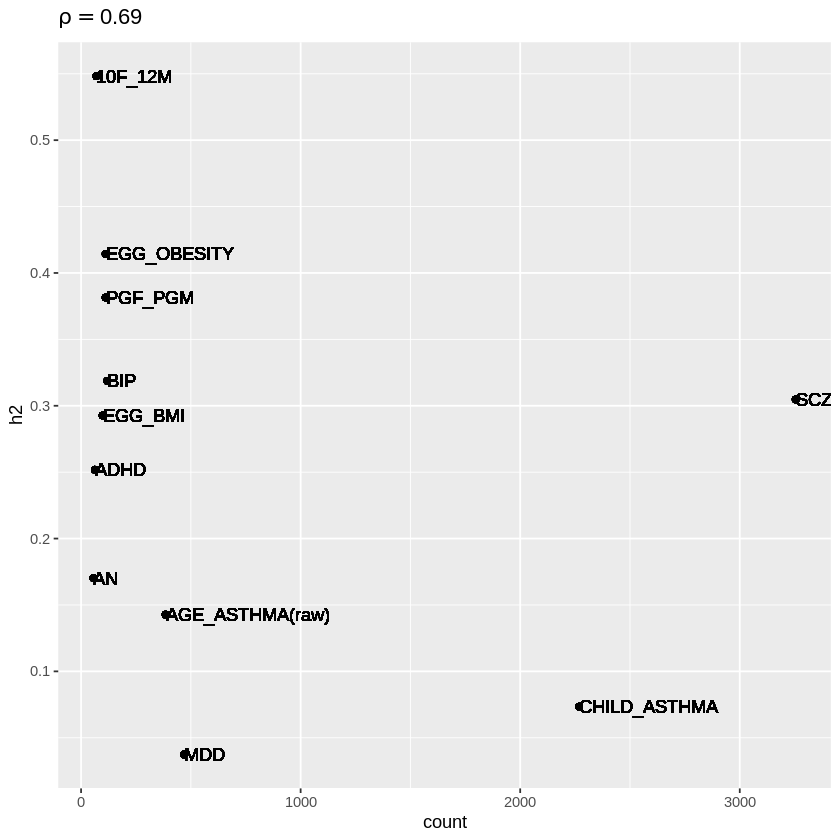

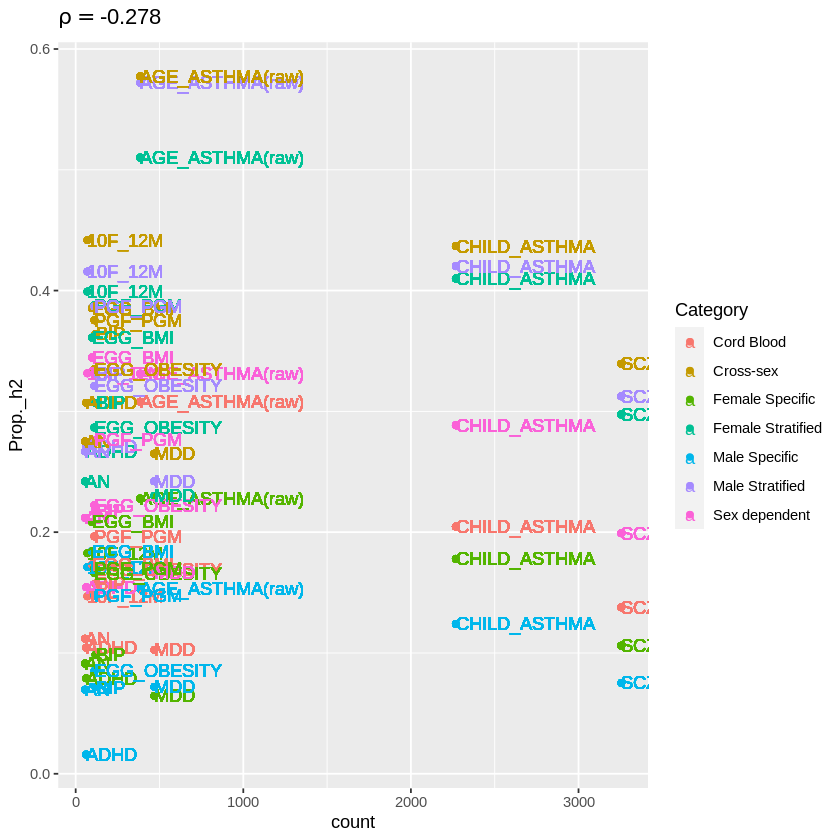

In [7]:
all_data <- merge(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df),sex_coloc_table,by="GWAS",allow.cartesian=TRUE)
df <- all_data[,.(count=sum(PP.H4.abf >0.9),h2,h2_std_error,Prop._h2,Category),by="GWAS"]
df <- df[(h2 / h2_std_error) > 1.64]
ggplot(df%>% filter(count != 0),aes(count,h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)+
    ggtitle(bquote(rho==.(round(cor.test(df$count,df$h2,method="spearman")$estimate,3))))


ggplot(df %>% filter(count != 0),aes(count,Prop._h2, color=Category, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)+
    ggtitle(bquote(rho==.(round(cor.test(df$count,df$Prop._h2,method="spearman")$estimate,3))))

### Writing out data to a single table

In [6]:
to_write <- coloc_sex_manifest%>% filter(PP.H4.abf > 0.9,!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT|Hayfever Age|Asthma Age|Diabetes Age",GWAS))
to_write$gene <- to_write$UCSC_RefGene_Name
to_write$UCSC_RefGene_Name <- NULL
to_write$gene <- gsub(";.*","",to_write$gene)

to_write %>%
    filter(!grepl("EGG",GWAS))%>%
    select(Sex,GWAS,probe,gene,everything()) %>%
    arrange(GWAS,Sex,-PP.H4.abf) %>%
    write_csv(here("data","all_PH4_coloc.csv")) 


to_write <- coloc_sex_manifest%>% filter(PP.H4.abf > 0.5,!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT|Hayfever Age|Asthma Age|Diabetes Age",GWAS))
to_write$gene <- to_write$UCSC_RefGene_Name
to_write$UCSC_RefGene_Name <- NULL
to_write$gene <- gsub(";.*","",to_write$gene)

to_write %>%
    filter(!grepl("EGG",GWAS))%>%
    select(Sex,GWAS,probe,gene,everything()) %>%
    arrange(GWAS,Sex,-PP.H4.abf) %>%
    write_csv(here("data","all_PH4_50_coloc.csv")) 

ERROR: Error in filter(., PP.H4.abf > 0.9, !grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT|Hayfever Age|Asthma Age|Diabetes Age", : object 'coloc_sex_manifest' not found


### Enumerating colocalized loci
Intersection/difference in loci found for sex stratified GWAS & sex stratified placental mQTL vs cross-sex GWAS & cross-sex placental mQTL

In [8]:
selected_traits <- c(
    'ADHD',
    'SCZ',
    'AN',
    'CUD',
    'Child Onset Asthma',
    'Hayfever or Eczema Age',
    'Type 1 Diabetes',
    'Birth Weight',
    'Child BMI',
    'Child Obesity',
    'Pubertal Growth Start',
    'Late Pubertal Growth'
)
coloc_sex_manifest$GWAS <- recode(gsub(" \\(.*","",coloc_sex_manifest$GWAS),'Childhood BMI'='Child BMI','Childhood Onset Asthma'='Child Onset Asthma','Childhood Obesity'= 'Child Obesity')
all_coloc_summary <- coloc_sex_manifest[
    PP.H4.abf > 0.9 &
    GWAS %in% selected_traits,
    .(mQTL=paste0(unique(mQTL[order(mQTL)]),collapse=",")),
    by=c("probe","UCSC_RefGene_Name","GWAS")
][,.(
    nProbe=uniqueN(probe),
    nGene=uniqueN(gsub(";.*","",UCSC_RefGene_Name[UCSC_RefGene_Name != ""])),
    probe=paste0(unique(probe),collapse=","),
    gene=paste0(unique(gsub(";.*","",UCSC_RefGene_Name[UCSC_RefGene_Name != ""])),collapse=",")
    ),
    by=c("mQTL","GWAS")
]%>% mutate(mQTL= gsub("_mqtl","-stratified",mQTL))
fwrite(all_coloc_summary,file=here("data","colocalization-probe-gene.csv"))

In [9]:
all_coloc_summary[GWAS == "Child Onset Asthma"]

mQTL,GWAS,nProbe,nGene,probe,gene
<chr>,<chr>,<int>,<int>,<chr>,<chr>
cross-sex,Child Onset Asthma,57,36,"cg00255919,cg00593414,cg01031999,cg01570182,cg01687878,cg01935221,cg02030452,cg02145916,cg03416812,cg03798162,cg04554928,cg04689890,cg05429769,cg05533539,cg06364920,cg06896281,cg06898831,cg08331398,cg08809223,cg09179987,cg09329266,cg09390974,cg09788082,cg09991769,cg10690152,cg11611097,cg12136906,cg13353717,cg14196790,cg14786185,cg14799927,cg15072976,cg15470658,cg15486123,cg15888463,cg16162930,cg16796354,cg17480646,cg17637045,cg17865955,cg17951613,cg18185554,cg18810026,cg19891440,cg20051715,cg20534585,cg22445447,cg22706866,cg22719314,cg23704085,cg25597745,cg26019600,cg27125505,cg27320213,cg27321913,cg27473871,ch.6.751103R","IRF1,STK19,BRD2,PVT1,ZNF76,TRIM26,TRIM15,RAD50,MAPT,PSMB8,POU5F1,CD247,TCF19,NFKB1,SBNO2,TRAF3,DDAH2,FLG,HLA-DQB1,SLC22A5,GAL3ST2,IVL,ILDR1,SIPA1,HLA-DQB2,ITPR3,STAT5B,EFEMP2,LRRC33,RTF1,HRNR,COL11A2,LOC644172,STAT6,DEF6,CCHCR1"
"cross-sex,male-stratified",Child Onset Asthma,13,8,"cg00585698,cg01505556,cg03780997,cg04518342,cg07403865,cg07899411,cg14331998,cg14971718,cg17964422,cg19885979,cg24032190,cg24636541,cg26879891","CDK2AP1,TRIM26,CCHCR1,PDLIM4,BCL6,HCG27,SMAD3,HRNR"
female-stratified,Child Onset Asthma,45,13,"cg00628211,cg00688979,cg01086672,cg01190171,cg01717973,cg01793865,cg02164110,cg02288747,cg02652369,cg02879159,cg03130962,cg04676934,cg04898211,cg05008570,cg05325934,cg05522349,cg06652085,cg06833981,cg07278158,cg08160477,cg09798996,cg11583907,cg11982471,cg12044213,cg12748446,cg15374898,cg16519772,cg17114475,cg17217478,cg20217307,cg20921096,cg21165793,cg21334609,cg21441945,cg21497082,cg21912938,cg22150763,cg22933800,cg24859800,cg25637655,cg26512045,cg26586118,cg27014438,cg27092297,cg27191651","CCHCR1,OAZ3,TCF19,TRIM15,JAZF1,BAT2,BAT1,NOTCH4,HLA-DRB6,HLA-DPB2,BAT3,HLA-DQA1,HLA-A"
male-stratified,Child Onset Asthma,19,9,"cg00738945,cg00888758,cg02432487,cg02948656,cg07078732,cg09199225,cg11344574,cg11439393,cg14161269,cg14624895,cg16689962,cg17495555,cg18485872,cg18896979,cg19556854,cg20700740,cg22775801,cg24583287,cg26020982","C6orf10,HRNR,AGER,BRD2,TNXB,CCHCR1,AGPAT1,ZBTB38,NEU4"
"cross-sex,female-stratified,male-stratified",Child Onset Asthma,53,23,"cg01140214,cg01222168,cg02247838,cg02299328,cg02698622,cg02738086,cg02936049,cg03782662,cg03806693,cg03961010,cg04809988,cg05159804,cg05247661,cg05583848,cg06400745,cg06656924,cg07392085,cg07824663,cg08207604,cg08670715,cg08850243,cg10169515,cg10400081,cg10985055,cg12609785,cg13285319,cg13853198,cg14110444,cg14438695,cg15175608,cg15316118,cg15633388,cg17117718,cg17365725,cg17647271,cg18394648,cg18395189,cg18825221,cg19197236,cg19455396,cg20345556,cg20416874,cg21010569,cg21138405,cg22356347,cg22463097,cg22687902,cg22968622,cg23193657,cg23475993,cg24465943,cg26413900,cg27157575","CCHCR1,D2HGDH,RAPGEFL1,POLR3H,ZBTB38,TRIM26,ZNF365,LBH,DEF6,ZNF76,NDFIP1,SBNO2,MPHOSPH9,FCER1G,C6orf25,POU5F1,HRNR,RAD51L1,TAP2,RERE,IRF1,CD247,MAPT"
"female-stratified,male-stratified",Child Onset Asthma,4,3,"cg04917860,cg12564285,cg15498513,cg20356878","PDLIM4,TCF19,ILDR1"
"cross-sex,female-stratified",Child Onset Asthma,5,3,"cg16439324,cg18050521,cg18795955,cg19063856,cg22158929","TCF19,CCHCR1,RAPGEFL1"


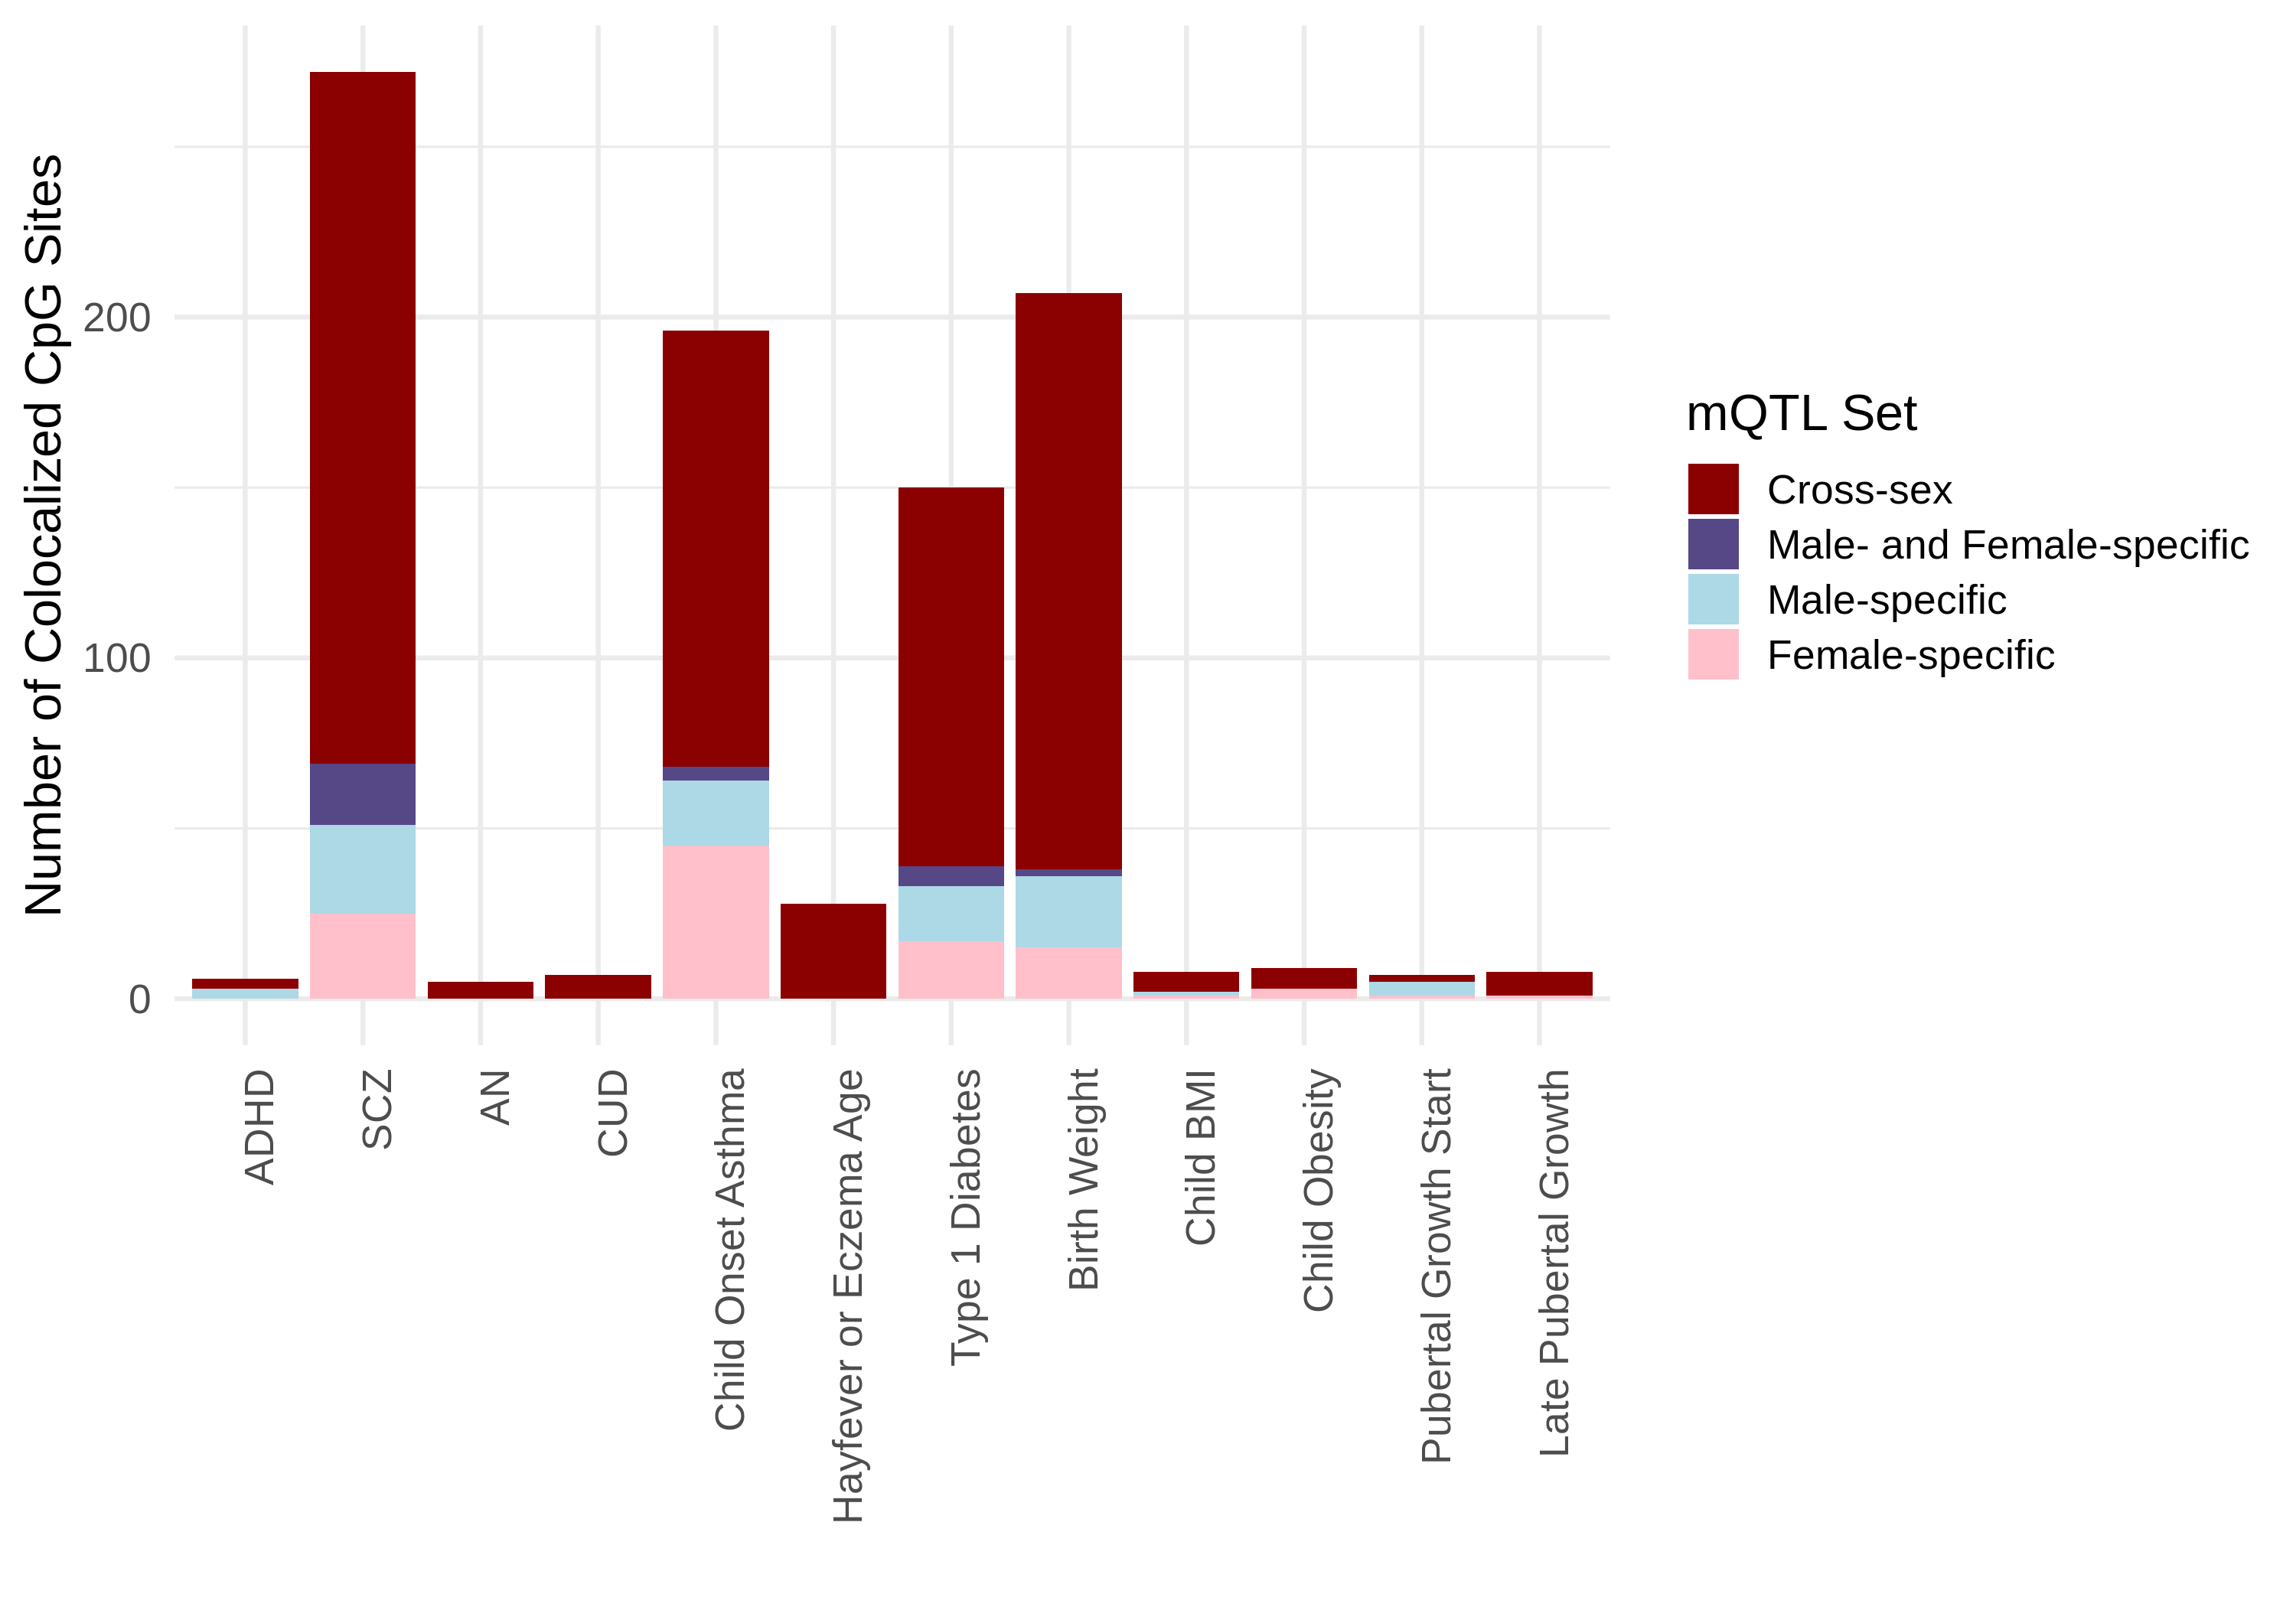

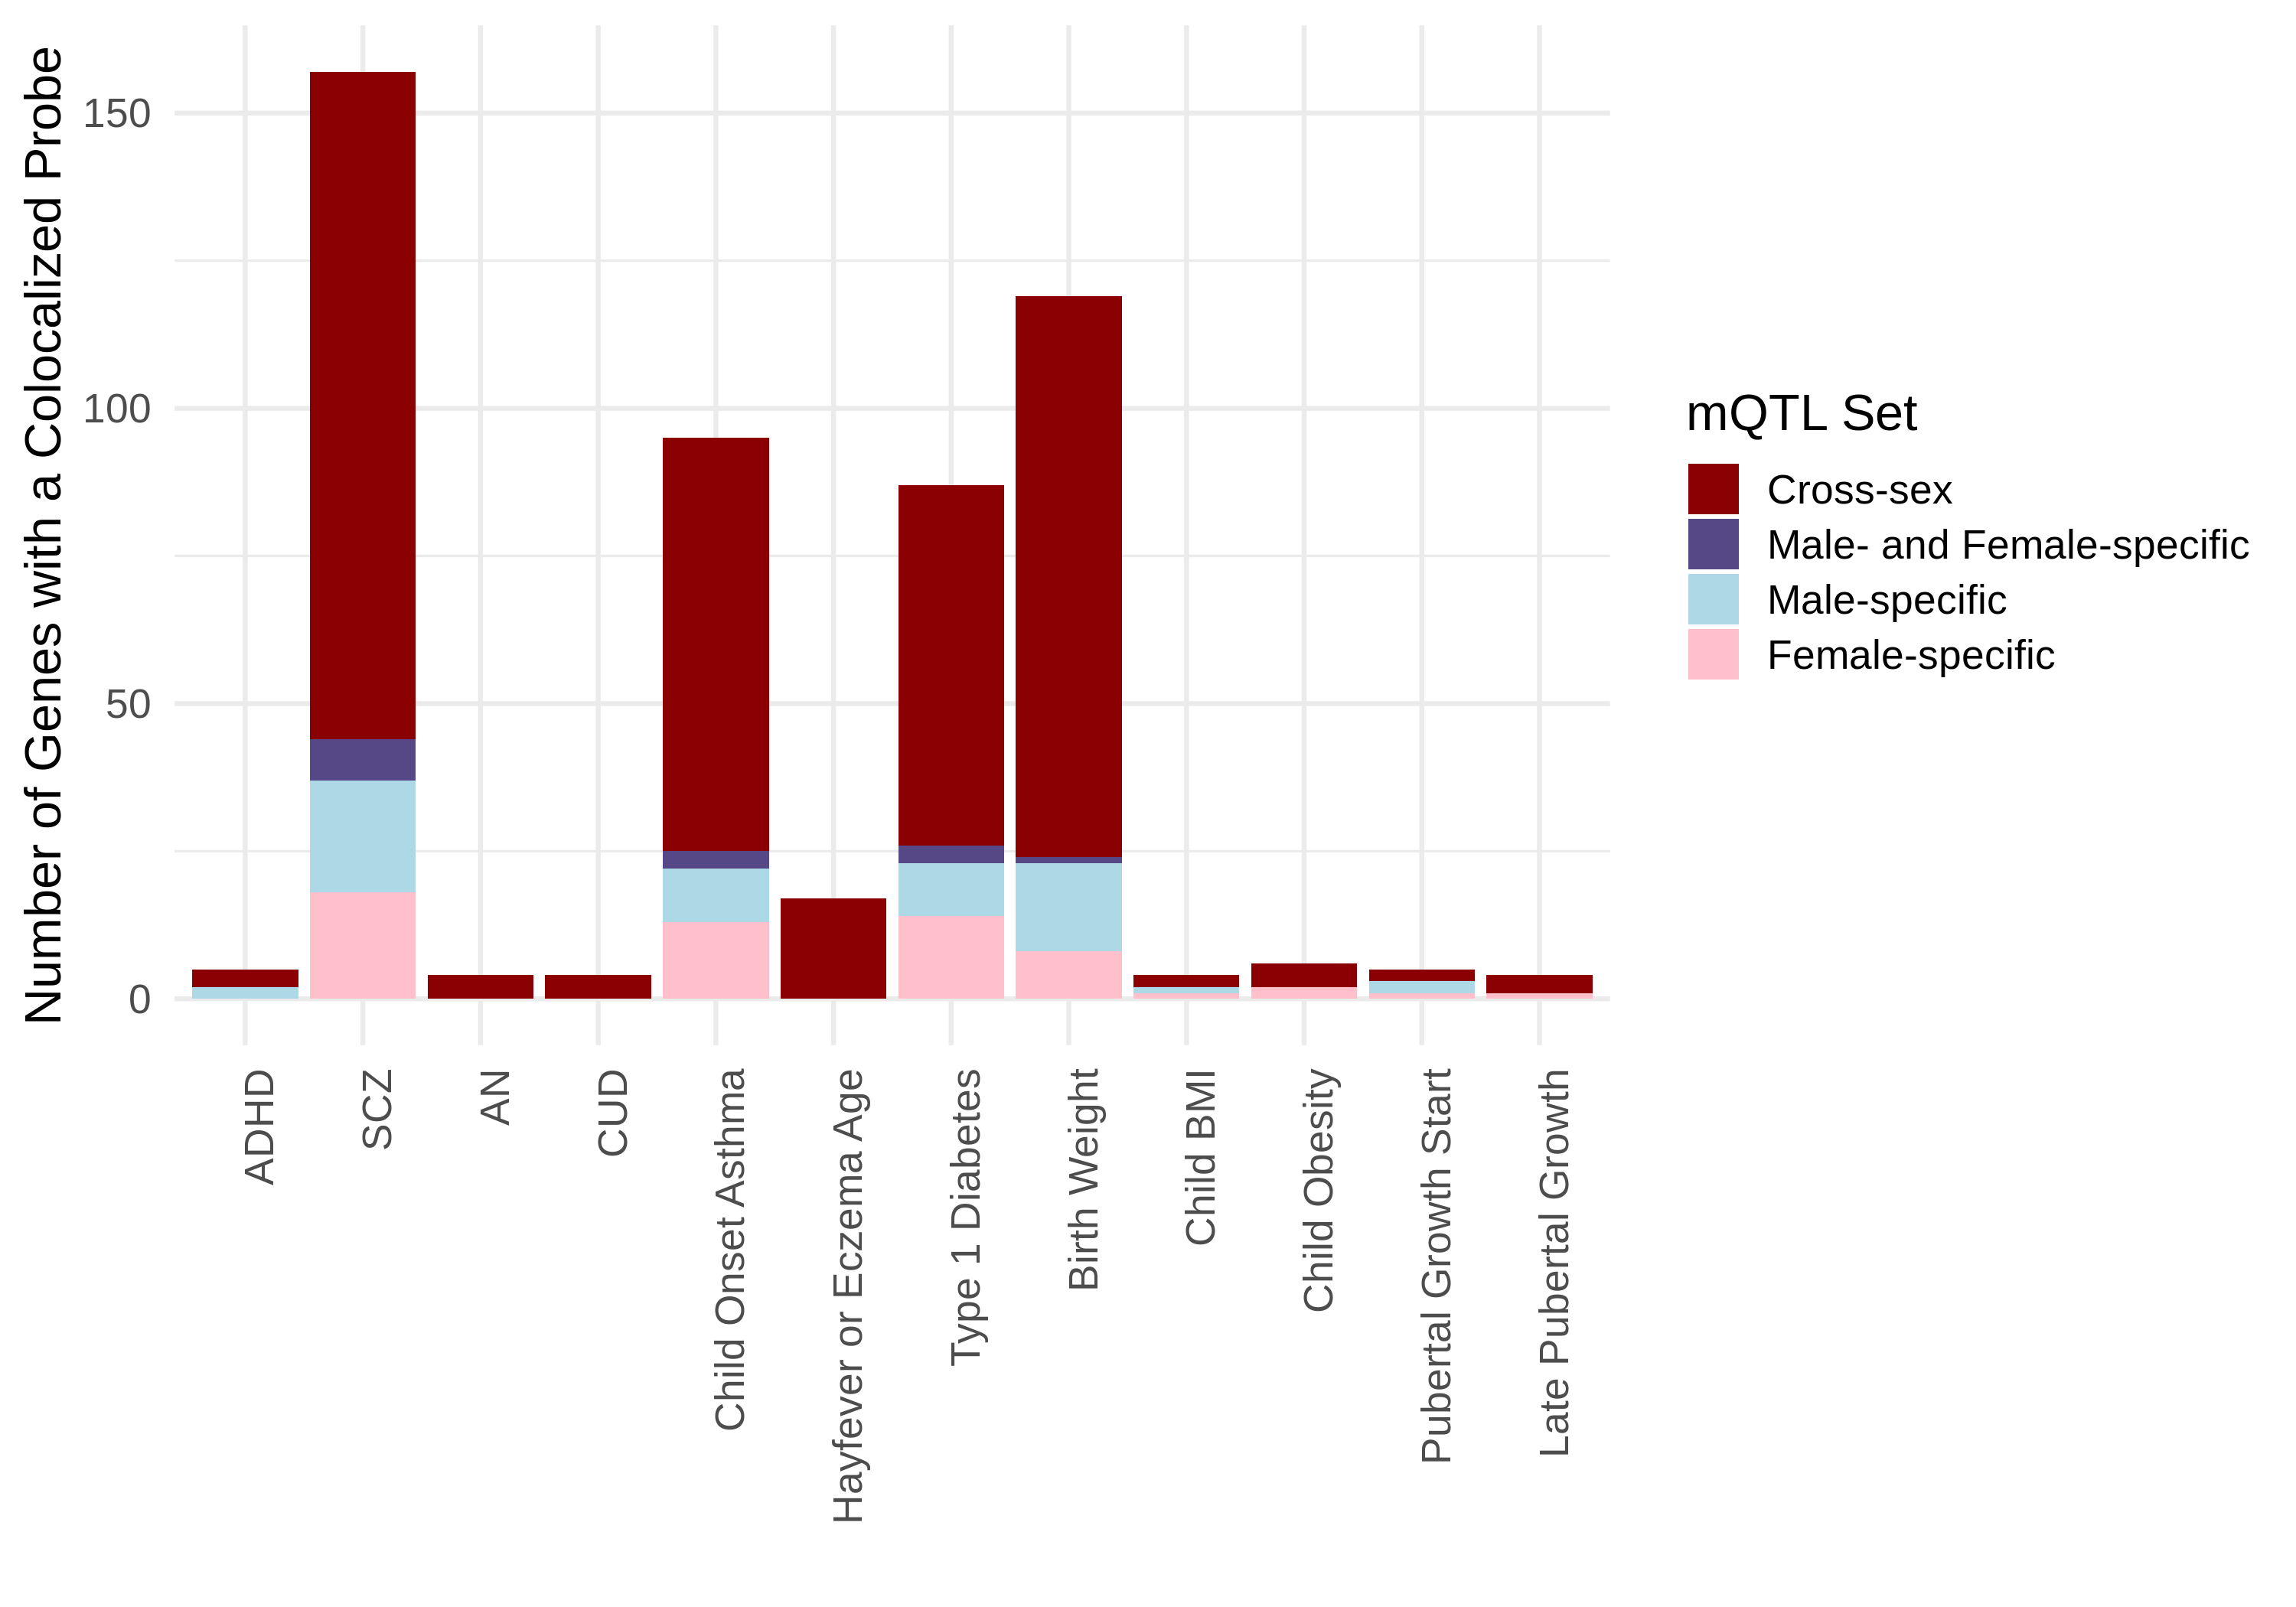

In [10]:
options(width=10,repr.plot.width= 10, repr.plot.height= 7, repr.plot.res = 300)

ggplot(
    all_coloc_summary %>%
    mutate(`mQTL Set`=replace(mQTL,grepl("cross-sex",mQTL),"Cross-sex"),GWAS = factor(GWAS,levels=selected_traits))%>%
    mutate(`mQTL Set`=recode_factor(`mQTL Set`,"cross-sex"="Cross-sex","female-stratified,male-stratified"="Male- and Female-specific","male-stratified"="Male-specific","female-stratified"="Female-specific")),
    aes(GWAS,nProbe,fill=`mQTL Set`)) +
    geom_col() +
    labs(y="Number of Colocalized CpG Sites",x="") +
    scale_fill_manual(values=c("dark red", "#564787","light blue", "pink"))+
    theme_minimal(base_size = 16)+
    theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))

ggplot(
    all_coloc_summary %>%
    mutate(`mQTL Set`=replace(mQTL,grepl("cross-sex",mQTL),"Cross-sex"),GWAS = factor(GWAS,levels=selected_traits))%>%
    mutate(`mQTL Set`=recode_factor(`mQTL Set`,"cross-sex"="Cross-sex","female-stratified,male-stratified"="Male- and Female-specific","male-stratified"="Male-specific","female-stratified"="Female-specific")),
    aes(GWAS,nGene,fill=`mQTL Set`)) +
    geom_col() +
    labs(y="Number of Genes with a Colocalized Probe",x="") +
    scale_fill_manual(values=c("dark red","#564787","light blue", "pink"))+
    theme_minimal(base_size = 16)+
    theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))

##  Visualizing top colocalized sites for child onset asthma

Selecting top loci:    

In [11]:
#select male only female only, and cross-sex examples
colocalization_by_probe <- coloc_sex_manifest[
    PP.H4.abf > 0.9 &
    GWAS %in% selected_traits,
    .(mQTL=paste0(unique(mQTL[order(mQTL)]),collapse=",")),
    by=c("probe","UCSC_RefGene_Name","GWAS")
]
selection_set <- colocalization_by_probe %>%
    mutate(`mQTL Set`=replace(mQTL,grepl("cross-sex",mQTL),"Cross-sex"),GWAS = factor(GWAS,levels=selected_traits))%>%
    mutate(`mQTL Set`=recode_factor(`mQTL Set`,"cross-sex"="Cross-sex","female_mqtl,male_mqtl"="Male- and Female-specific","male_mqtl"="Male-specific","female_mqtl"="Female-specific"))
female_ex <- unlist(strsplit(selection_set[GWAS == "Child Onset Asthma" & `mQTL Set` == "Female-specific"]$probe,","))
male_ex <- unlist(strsplit(selection_set[GWAS == "Child Onset Asthma" & `mQTL Set` == "Male-specific"]$probe,","))
cross_ex <- unlist(strsplit(selection_set[GWAS == "Child Onset Asthma" & `mQTL Set` == "Cross-sex"]$probe,","))
coloc_sex_manifest[GWAS == "Child Onset Asthma" & mQTL == "female_mqtl" & probe %in% female_ex][order(-PP.H4.abf)]
coloc_sex_manifest[GWAS == "Child Onset Asthma" & mQTL == "male_mqtl" & probe %in% male_ex][order(-PP.H4.abf)]
coloc_sex_manifest[GWAS == "Child Onset Asthma" & grepl("cross-sex",mQTL) & probe %in% cross_ex][order(-PP.H4.abf)]
fwrite(data.frame(cpgs = c(cross_ex,male_ex,female_ex)),here("data","asthma_coloc_cpgs.txt"))

probe,GWAS,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,mQTL,UCSC_RefGene_Name
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg01717973,Child Onset Asthma,14,1.149360e-20,3.867127e-12,2.972130e-12,2.931912e-13,1.0000000,female_mqtl,OAZ3;MRPL9
cg09798996,Child Onset Asthma,98,9.389916e-20,8.121642e-17,4.041909e-06,2.498481e-03,0.9974975,female_mqtl,NOTCH4
cg20921096,Child Onset Asthma,90,1.440097e-05,3.181751e-05,1.303287e-03,1.882714e-03,0.9967678,female_mqtl,BAT3;BAT3;BAT3;BAT3
cg08160477,Child Onset Asthma,69,2.313856e-07,4.899031e-06,3.376973e-04,6.156425e-03,0.9935007,female_mqtl,BAT1;BAT1
cg27014438,Child Onset Asthma,62,1.394347e-14,1.672440e-08,1.022937e-08,1.128083e-02,0.9887191,female_mqtl,BAT3;BAT3;BAT3;BAT3
cg21441945,Child Onset Asthma,31,1.456877e-09,2.183630e-04,1.147277e-07,1.621231e-02,0.9835692,female_mqtl,OAZ3;OAZ3
cg05008570,Child Onset Asthma,319,9.998074e-21,1.709012e-16,1.819047e-06,3.012384e-02,0.9698743,female_mqtl,TCF19;TCF19
cg05325934,Child Onset Asthma,73,6.368949e-13,4.530897e-11,4.729961e-04,3.268230e-02,0.9668447,female_mqtl,JAZF1
cg02879159,Child Onset Asthma,173,2.916023e-11,3.023169e-05,3.493144e-08,3.525023e-02,0.9647195,female_mqtl,TRIM15


probe,GWAS,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,mQTL,UCSC_RefGene_Name
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg16689962,Child Onset Asthma,87,2.224868e-14,2.294923e-09,1.928956e-08,0.0009906847,0.9990093,male_mqtl,AGPAT1;AGPAT1
cg17495555,Child Onset Asthma,62,9.368538e-12,2.689812e-05,2.403604e-09,0.0059069481,0.9940662,male_mqtl,ZBTB38
cg00738945,Child Onset Asthma,205,1.686228e-26,3.361413e-26,3.100297e-03,0.0051885810,0.9917111,male_mqtl,C6orf10
cg11439393,Child Onset Asthma,174,2.764625e-14,1.815182e-08,1.414185e-08,0.0082934722,0.9917065,male_mqtl,BRD2;BRD2
cg19556854,Child Onset Asthma,174,4.683481e-16,2.247282e-08,2.349313e-10,0.0102830265,0.9897170,male_mqtl,BRD2;BRD2
cg11344574,Child Onset Asthma,182,8.822508e-13,1.715603e-08,1.519882e-06,0.0285838343,0.9714146,male_mqtl,HRNR
cg00888758,Child Onset Asthma,136,2.120115e-13,1.737201e-08,3.652391e-07,0.0289562763,0.9710433,male_mqtl,HRNR
cg18896979,Child Onset Asthma,228,2.814399e-09,4.526166e-04,2.220460e-07,0.0347450309,0.9648021,male_mqtl,
cg26020982,Child Onset Asthma,41,1.215781e-12,2.080003e-08,2.482797e-06,0.0415181380,0.9584794,male_mqtl,HRNR


probe,GWAS,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,mQTL,UCSC_RefGene_Name
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg02698622,Child Onset Asthma,152,1.580032e-93,3.794372e-39,4.166333e-58,5.252196e-07,0.9999995,cross-sex,D2HGDH
cg17365725,Child Onset Asthma,153,9.149392e-129,3.794372e-39,2.412572e-93,5.252196e-07,0.9999995,cross-sex,D2HGDH
cg19197236,Child Onset Asthma,152,1.312309e-65,3.794372e-39,3.460382e-30,5.252196e-07,0.9999995,cross-sex,D2HGDH
cg01222168,Child Onset Asthma,149,6.979999e-61,3.794373e-39,1.840532e-25,5.254991e-07,0.9999995,cross-sex,D2HGDH
cg16796354,Child Onset Asthma,16,1.832597e-09,1.781787e-05,1.028505e-07,7.119584e-09,0.9999821,cross-sex,ILDR1
cg27320213,Child Onset Asthma,55,4.676261e-23,4.511321e-18,1.213007e-08,1.703927e-04,0.9998296,cross-sex,STAT6;STAT6
cg24465943,Child Onset Asthma,72,8.407390e-24,1.230555e-08,1.009495e-18,4.780351e-04,0.9995220,cross-sex,FCER1G
cg13853198,Child Onset Asthma,97,2.414626e-38,1.294312e-08,2.899299e-33,5.546662e-04,0.9994453,cross-sex,FCER1G;FCER1G
cg25597745,Child Onset Asthma,974,2.016108e-59,3.197590e-57,1.197822e-05,9.006837e-04,0.9990873,cross-sex,HLA-DQB1


In [12]:
female_asthma <- coloc_sex_manifest[GWAS == "Child Onset Asthma" & mQTL == "female_mqtl" & probe %in% female_ex][order(-PP.H4.abf)]
male_asthma <- coloc_sex_manifest[GWAS == "Child Onset Asthma" & mQTL == "male_mqtl" & probe %in% male_ex][order(-PP.H4.abf)]
cross_asthma <- coloc_sex_manifest[GWAS == "Child Onset Asthma" & grepl("cross-sex",mQTL) & probe %in% cross_ex][order(-PP.H4.abf)]

In [43]:
# female_asthma[manifest[chr == "chr6" &  (pos <= 29677984 | pos >=  33485635)],on = c("probe" = "V1"),nomatch=0]
# male_asthma[manifest[chr == "chr6" &  (pos <= 29677984 | pos >= 33485635)],on = c("probe" = "V1"),nomatch=0]
# cross_asthma[manifest[chr == "chr6"],on = c("probe" = "V1"),nomatch=0][!duplicated(probe)][,.(sum((pos <= 29677984 | pos >= 33485635)),sum(!(pos <= 29677984 | pos >= 33485635)))]
#cross_asthma[manifest[chr != "chr6"],on = c("probe" = "V1"),nomatch=0][!duplicated(probe),.( .N, uniqueN(gsub(";.*","",UCSC_RefGene_Name)))]
cross_asthma[manifest[chr == "chr6"],on = c("probe" = "V1"),nomatch=0][!duplicated(probe),.( .N, uniqueN(gsub(";.*","",UCSC_RefGene_Name)))]
count_coloc <- rbind(
    cross_asthma[manifest,on = c("probe" = "V1"),nomatch=0],
    male_asthma[manifest,on = c("probe" = "V1"),nomatch=0],
    female_asthma[manifest,on = c("probe" = "V1"),nomatch=0]
)
count_coloc[!duplicated(probe)][,.( .N ),by="mQTL"]

count_coloc[mQTL == "cross-sex",.(
    total = .N,
    chr6nonHLA=sum(chr == "chr6" & (pos < 29677984 | pos > 33485635)),
    chr6HLA=sum(chr == "chr6" & (pos >= 29677984 | pos <= 33485635)),
    nonchr6=sum(chr != "chr6")
)]
cat(paste0(unique(unlist(strsplit(count_coloc[chr != "chr6" & mQTL  == "cross-sex",]$UCSC_RefGene_Name,";"))),"\n"))
count_coloc[mQTL == "male_mqtl",.(
    total = .N,
    chr6nonHLA=sum(chr == "chr6" & (pos < 29677984 | pos > 33485635)),
    chr6HLA=sum(chr == "chr6" & (pos >= 29677984 | pos <= 33485635)),
    nonchr6=sum(chr != "chr6")
)]
cat(paste0(unique(unlist(strsplit(count_coloc[chr != "chr6" & mQTL  == "male_mqtl",]$UCSC_RefGene_Name,";"))),"\n"))
cat(paste0(unique(unlist(strsplit(count_coloc[chr == "chr6" & mQTL  == "male_mqtl",]$UCSC_RefGene_Name,";"))),"\n"))

count_coloc[mQTL == "female_mqtl",.(
    total = .N,
    chr6nonHLA=sum(chr == "chr6" & (pos < 29677984 | pos > 33485635)),
    chr6HLA=sum(chr == "chr6" & (pos >= 29677984 | pos <= 33485635)),
    nonchr6=sum(chr != "chr6")
)]
cat(paste0(unique(unlist(strsplit(count_coloc[chr != "chr6" & mQTL  == "female_mqtl",]$UCSC_RefGene_Name,";"))),"\n"))
cat(paste0(unique(unlist(strsplit(count_coloc[chr == "chr6" & mQTL  == "female_mqtl",]$UCSC_RefGene_Name,";"))),"\n"))

N,V2
<int>,<int>
45,19


mQTL,N
<chr>,<int>
cross-sex,128
male_mqtl,19
female_mqtl,45


total,chr6nonHLA,chr6HLA,nonchr6
<int>,<int>,<int>,<int>
128,8,45,83


FLG
 HRNR
 D2HGDH
 LBH
 GAL3ST2
 BCL6
 LRRC33
 PDLIM4
 SLC22A5
 SIPA1
 CDK2AP1
 TRAF3
 SMAD3
 LOC644172
 SBNO2
 POLR3H
 CD247
 FCER1G
 IVL
 RERE
 ZBTB38
 ILDR1
 NFKB1
 IRF1
 RAD50
 NDFIP1
 PVT1
 ZNF365
 EFEMP2
 MPHOSPH9
 STAT6
 RAD51L1
 RTF1
 RAPGEFL1
 MAPT
 STAT5B


total,chr6nonHLA,chr6HLA,nonchr6
<int>,<int>,<int>,<int>
19,0,8,11


HRNR
 NEU4
 ZBTB38
CCHCR1
 TCF19
 C6orf10
 AGER
 BRD2
 TNXB
 AGPAT1


total,chr6nonHLA,chr6HLA,nonchr6
<int>,<int>,<int>,<int>
45,0,41,4


OAZ3
 MRPL9
 JAZF1
CCHCR1
 TCF19
 BAT3
 HLA-A
 TRIM15
 BAT2
 BAT1
 NOTCH4
 HLA-DRB6
 HLA-DPB2
 HLA-DQA1


Loading GWAS sumstats, mQTL:

In [16]:
# Load mQTL and GWAS
cross <- fread(here("data","asthma_coloc_cross_mQTL_mecs.txt"))[p < 0.05 & SNP %in% intersect(SNP,reference$map$marker.ID)]
male <- fread(here("data","asthma_coloc_male_mQTL_mecs.txt"))[p < 0.05 & SNP %in% intersect(SNP,reference$map$marker.ID)]
female <- fread(here("data","asthma_coloc_female_mQTL_mecs.txt"))[p < 0.05 & SNP %in% intersect(SNP,reference$map$marker.ID)]
asthma <- fread("../../../tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz")[SNP %in% intersect(SNP,reference$map$marker.ID)]

Retrieve colocalization probabilities for each SNP:

In [17]:
compute_coloc <- function(SNP,mqtl,gwas,s){# SNP must be in SNP column of mqtl and gwas
    D1 <- list(
            beta = mqtl$b,
            varbeta = mqtl$SE^2,
            snp = mqtl$SNP,
            position = mqtl$BP,
            N = 400,
            MAF = mqtl$Freq,
            type="quant"
        )
    D2 <- list(
            pvalues = pnorm(-abs(gwas$Z))*2,
            z=gwas$Z,
            snp = gwas$SNP,
            MAF = snp_MAF(reference$genotypes,ind.col = match(gwas$SNP,reference$map$marker.ID)),
            N = min(gwas$N),
            type="cc",
            s = s
        )
        return(coloc.abf(D1,D2))
} 

coloc_all_sets <- function(probe){
    res <- list()
    sets <- list(cross,male,female)
    name_sets <- c("cross","male","female")
    for(i in 1:length(sets)){
        cur_mqtl <- sets[[i]][Probe == probe]
        if(nrow(cur_mqtl[Probe==probe]) == 0){
            res[[i]] <- data.frame()
        }else{
            res[[i]] <- compute_coloc(
                cur_mqtl$SNP,
                cur_mqtl,
                na.omit(asthma[cur_mqtl,on="SNP"]),
                s=0.0288
            )$results
            res[[i]]$set <- name_sets[i]
        }
    }
    return(rbindlist(res))
}

In [18]:
cross$cross_p <- cross$p
male$male_p <- male$p
female$female_p <- female$p

merged_mQTL <- Reduce(function(...) {merge(...,all = TRUE,by=c("SNP","Probe"))},list(cross,male,female))
merged_all <- merge(merged_mQTL,asthma,by="SNP",all=TRUE)

Warning message in merge.data.table(merged_mQTL, asthma, by = "SNP", all = TRUE):
“column names 'A1.x', 'A2.x', 'A2.y', 'A1.y' are duplicated in the result”


Warning message:
“Removed
123
rows
containing
missing
values
(geom_point).”


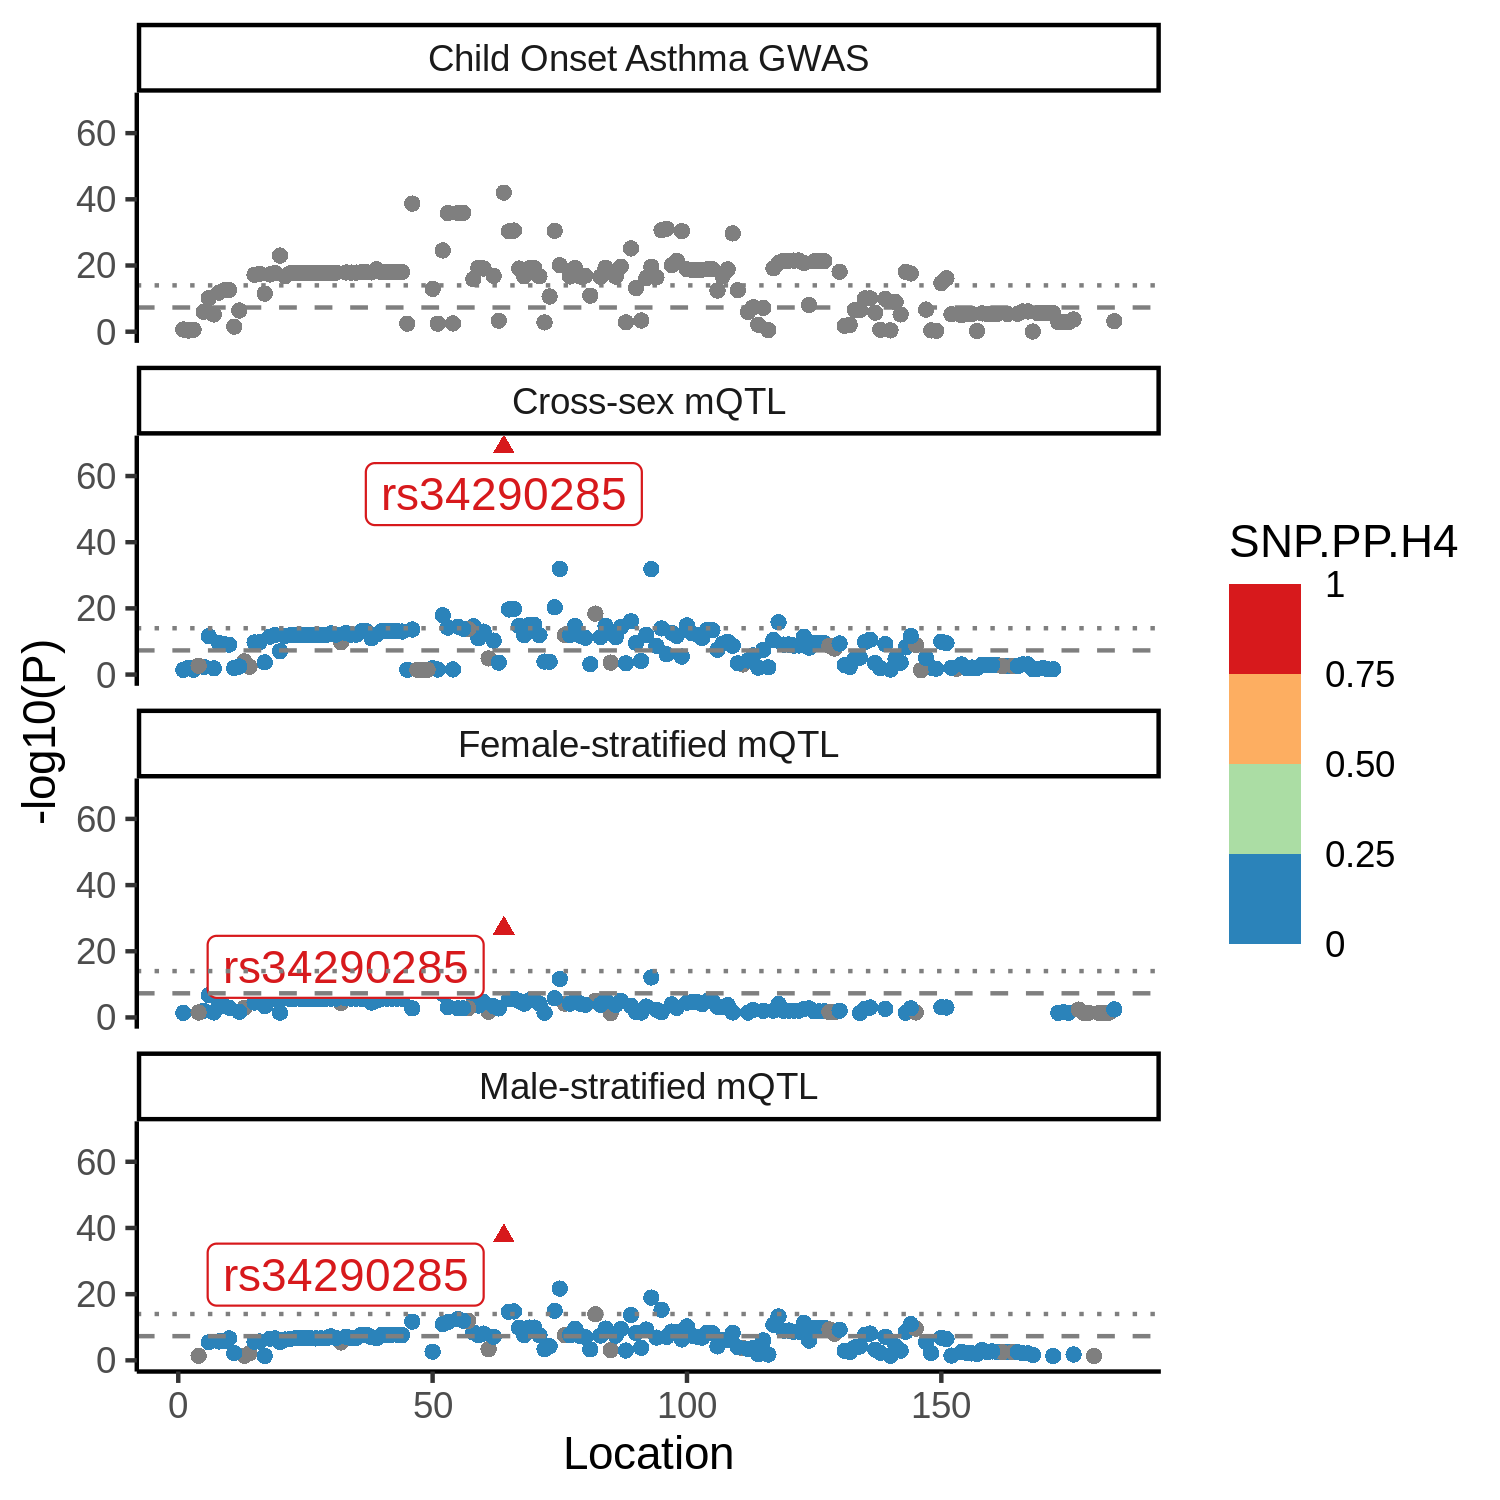

In [19]:
options(width=10,repr.plot.width= 5, repr.plot.height= 5, repr.plot.res = 300)
library(ggrepel)
plot_coloc <- function(probe){
    to_plot <- melt(
        merged_all[Probe == probe][order(BP.x)][,.(SNP,male=male_p,female=female_p,cross=cross_p,asthma=pnorm(-abs(Z)) * 2,Location=.I)],
        id.vars=c("SNP","Location")
    )
    suppressWarnings(capture.output(to_plot <- merge(to_plot,coloc_all_sets(probe),by.x = c("SNP","variable"), by.y=c("snp","set"),all = TRUE)))
    to_plot <- to_plot %>% group_by(variable) %>% mutate(`Max SNP H4`= ifelse(!is.na(SNP.PP.H4),SNP.PP.H4 == max(SNP.PP.H4,na.rm=TRUE),FALSE))
    final <- to_plot %>% 
        mutate(
            P = value,
            variable = recode(variable,"asthma"="Child Onset Asthma GWAS","cross"="Cross-sex mQTL", "male"= "Male-stratified mQTL","female"="Female-stratified mQTL")
        )
    p <- ggplot(final,aes(Location,-log10(P),color=SNP.PP.H4,shape=`Max SNP H4`)) +
            geom_point() +
            geom_label_repel(data=subset(final,`Max SNP H4`),aes(label=SNP)) +
            geom_hline(yintercept = -log10(5e-8),linetype="dashed",color="gray50")+
            geom_hline(yintercept = -log10(1e-14),linetype="dotted",color="gray50")+
            facet_wrap(~variable,nrow=4)+
            guides(shape=FALSE)+
            scale_color_fermenter(palette = "Spectral",show.limits=TRUE)+
            scale_shape_discrete()+
            theme_classic()
    return(p)
}
print(p <- plot_coloc("cg02698622"))

Warning message:
“Removed
91 rows
containing
missing
values
(geom_point).”


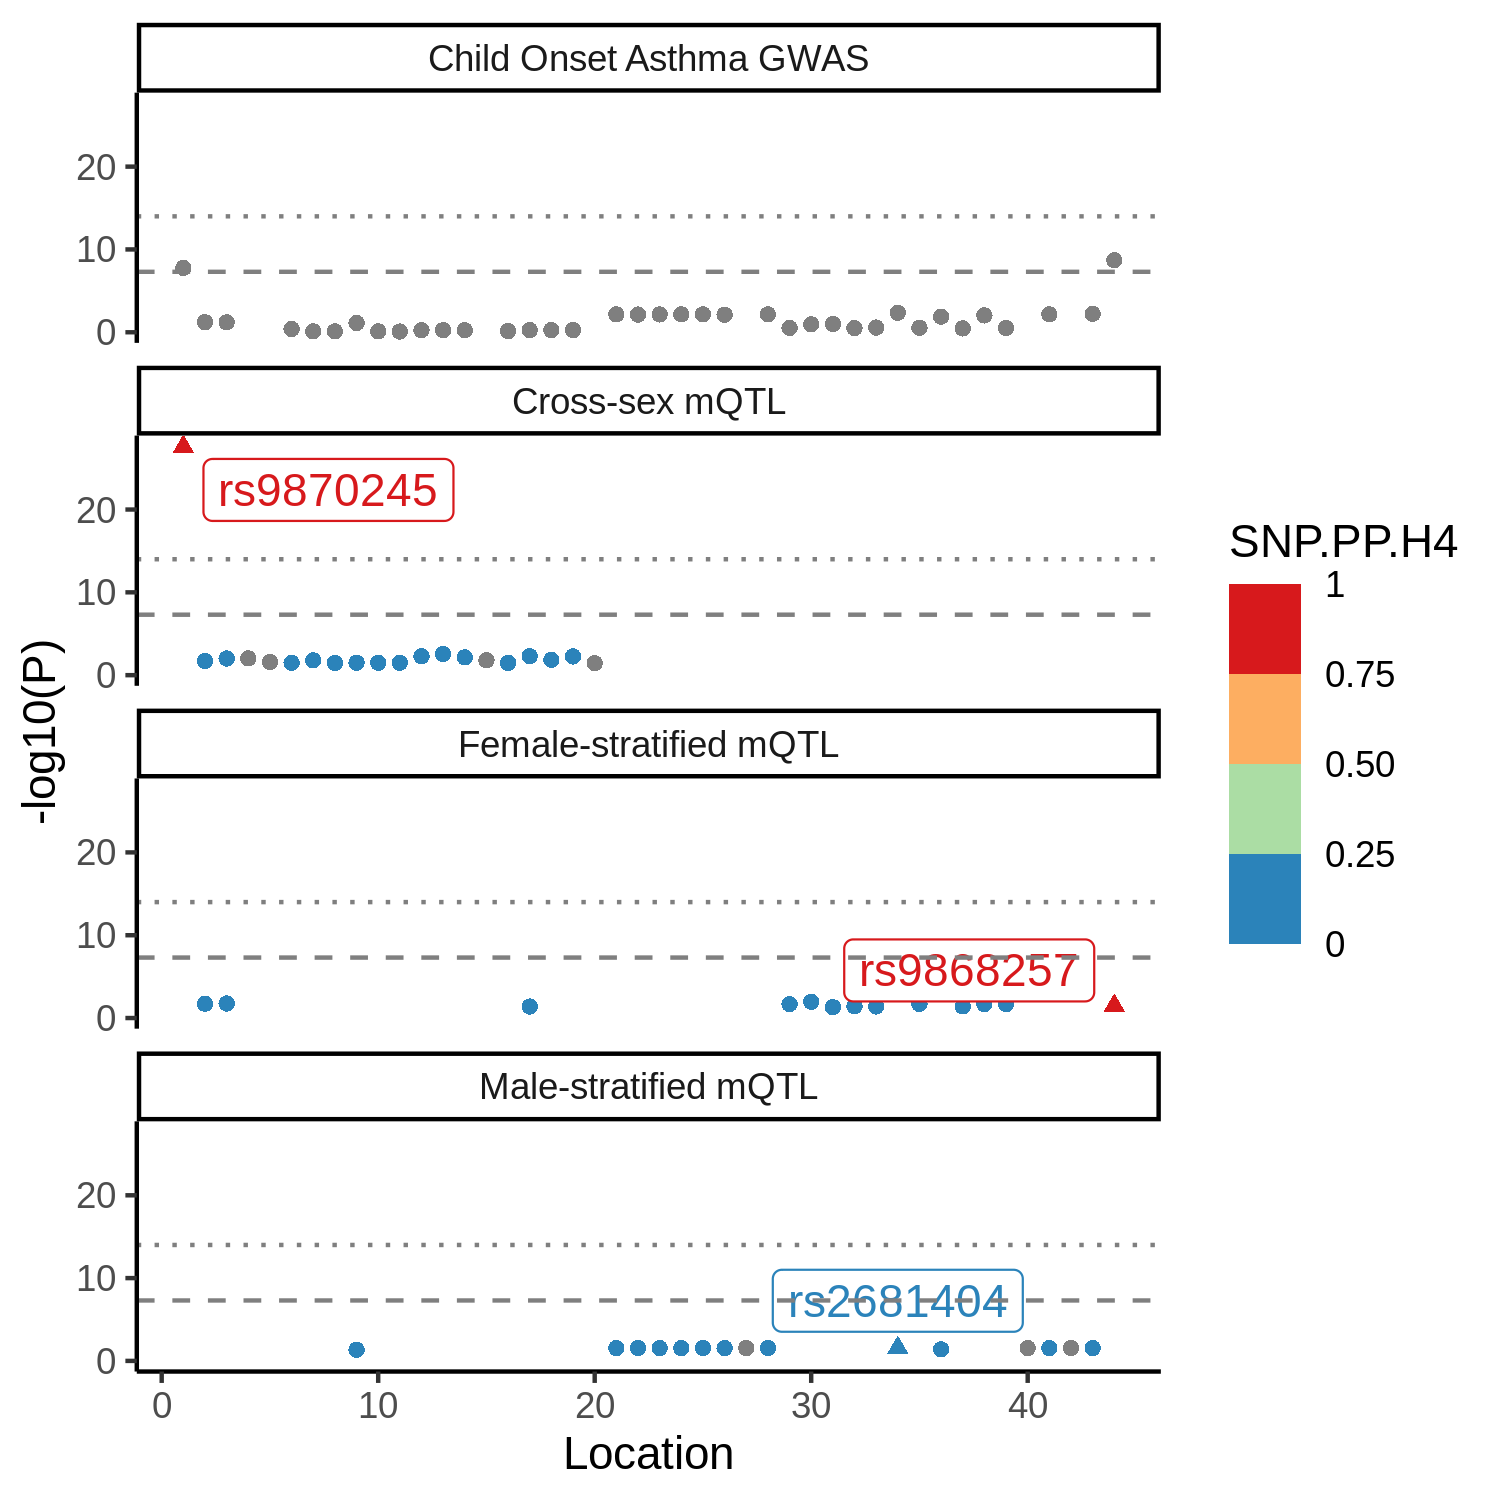

In [21]:
plot_coloc("cg16796354")

Warning message:
“Removed
68 rows
containing
missing
values
(geom_point).”


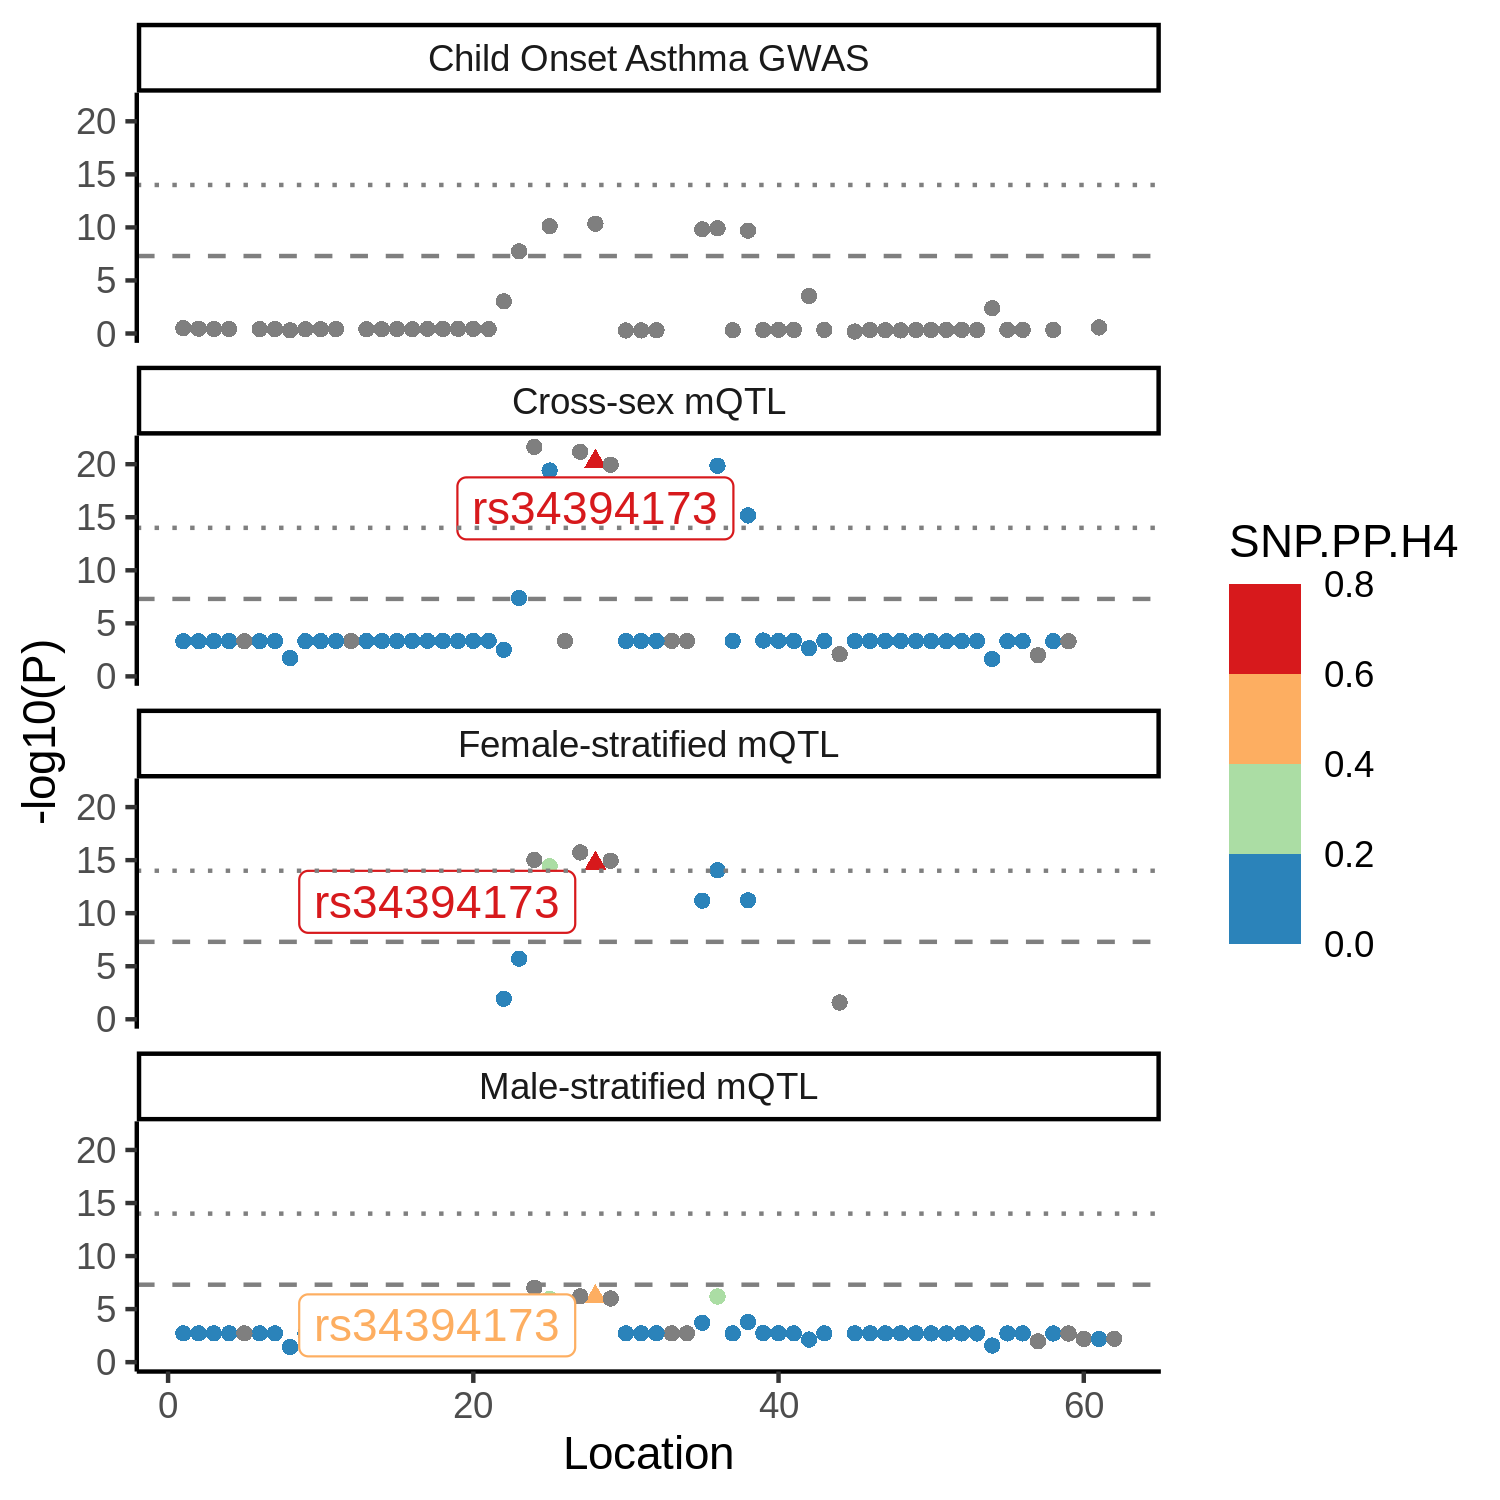

In [18]:
plot_coloc("cg19063856")

Warning message:
“Removed
115
rows
containing
missing
values
(geom_point).”


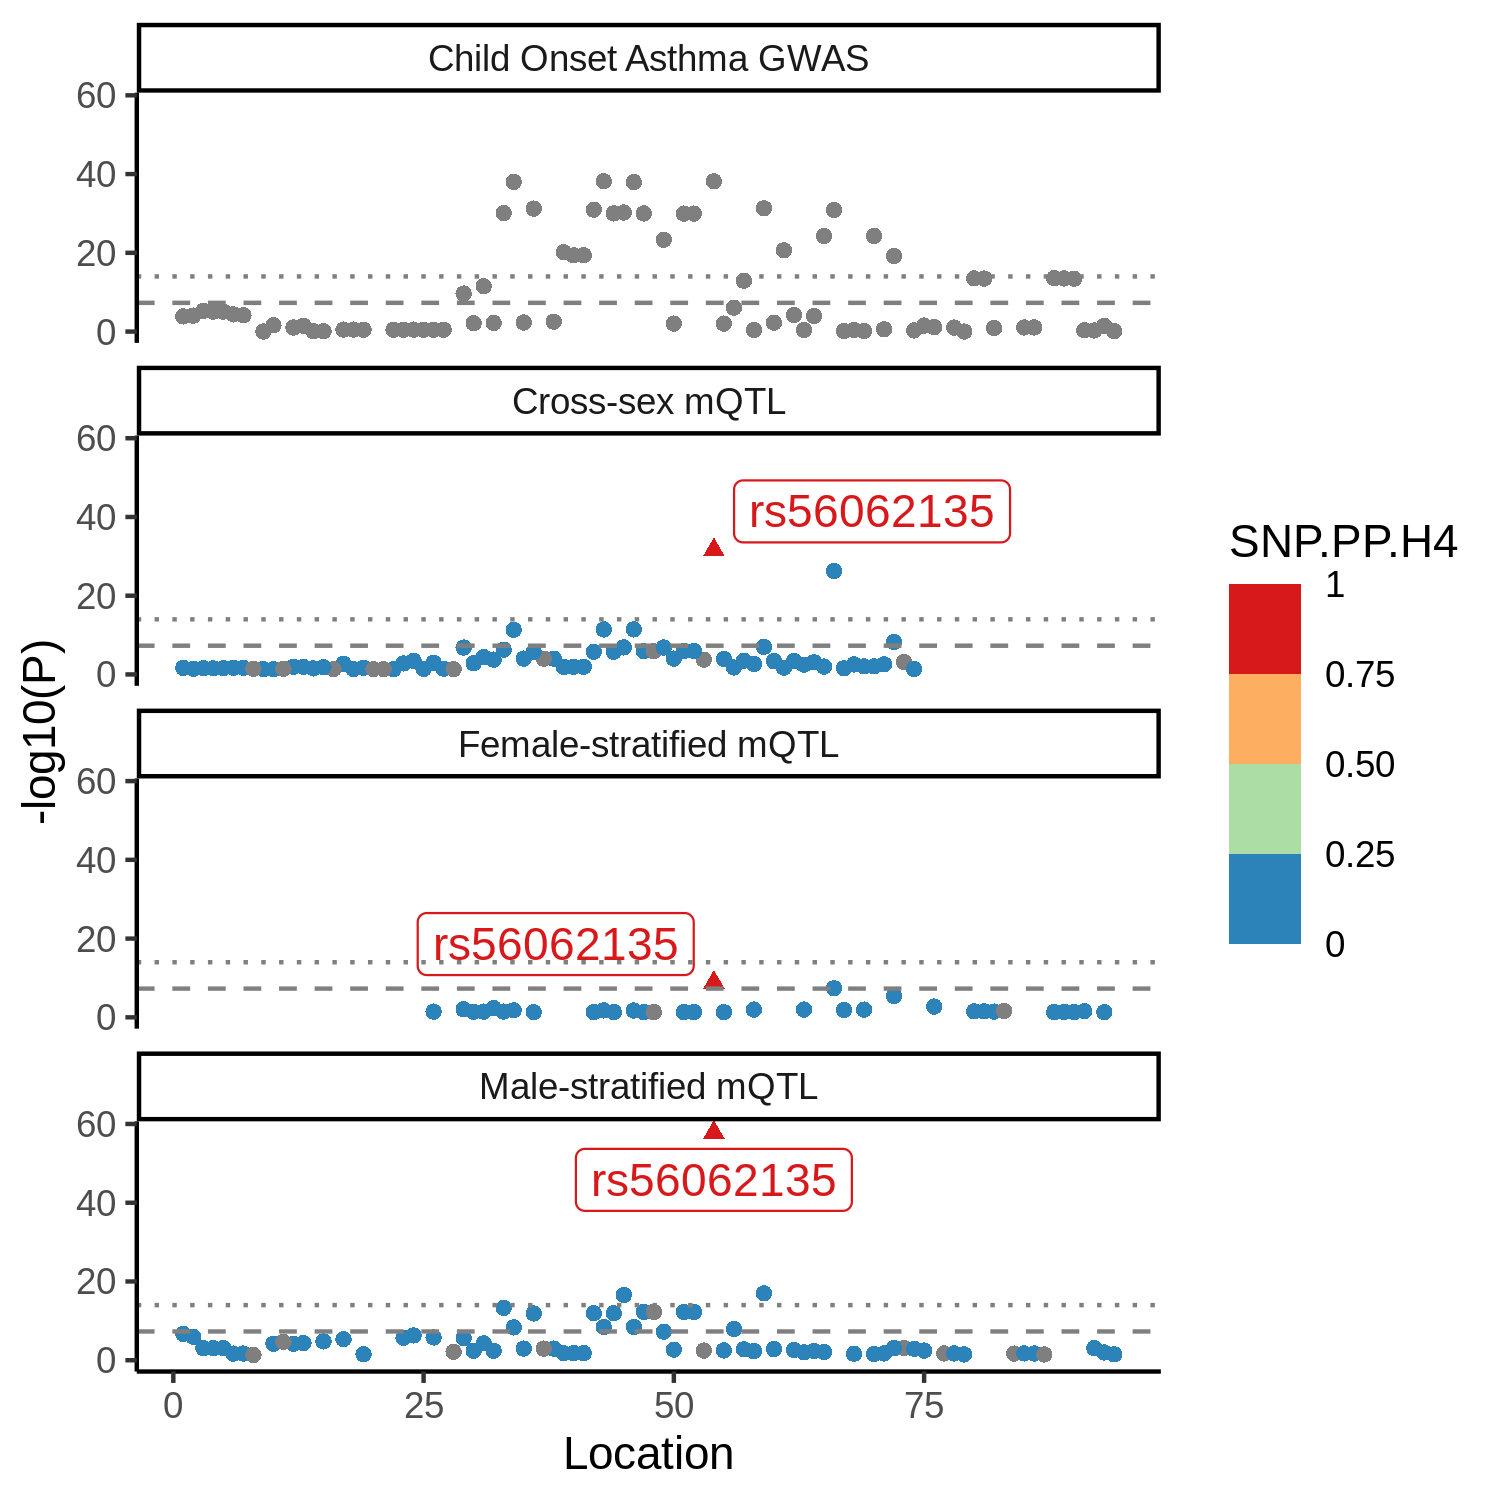

In [20]:
plot_coloc("cg24032190")

Warning message:
“Removed
129
rows
containing
missing
values
(geom_point).”


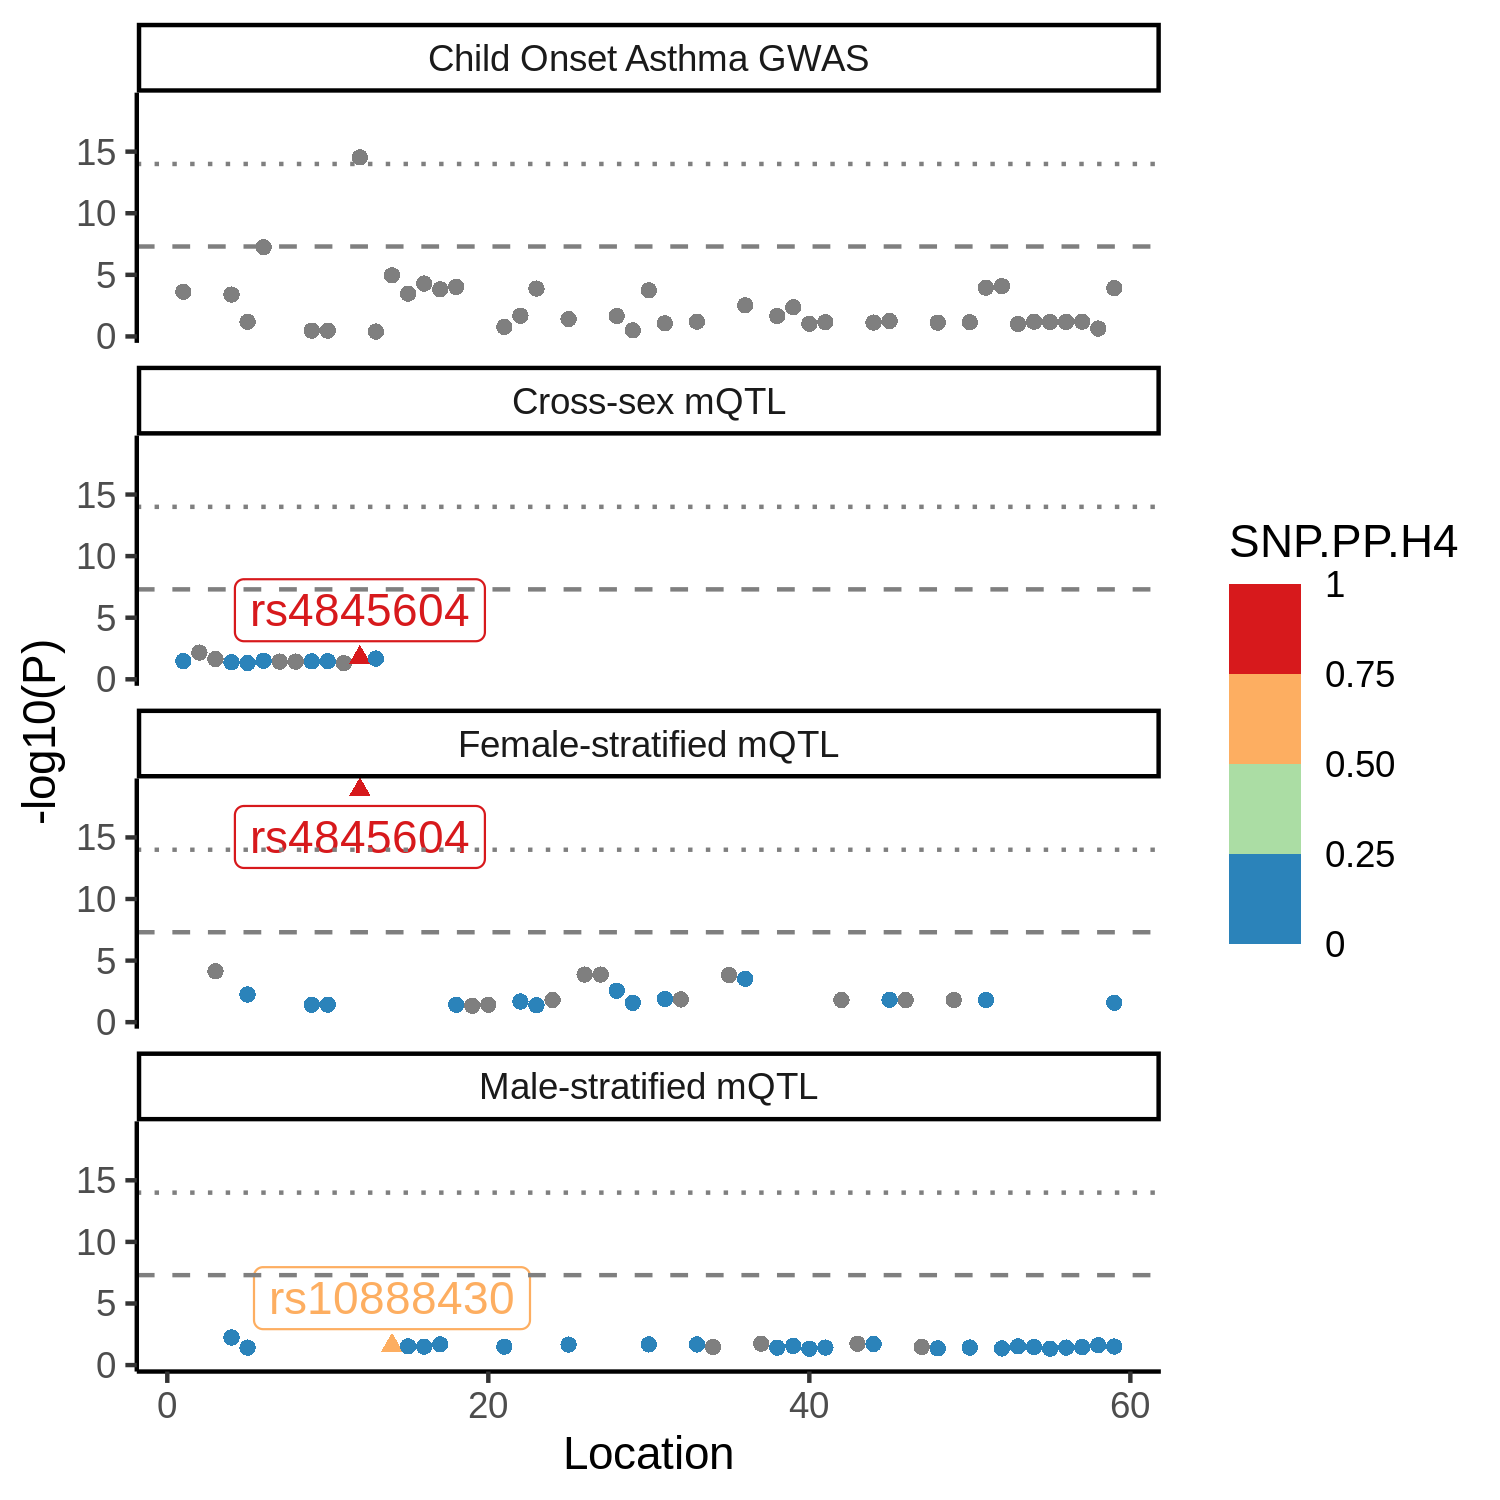

In [26]:
plot_coloc("cg01717973")

Warning message:
“Removed
261
rows
containing
missing
values
(geom_point).”


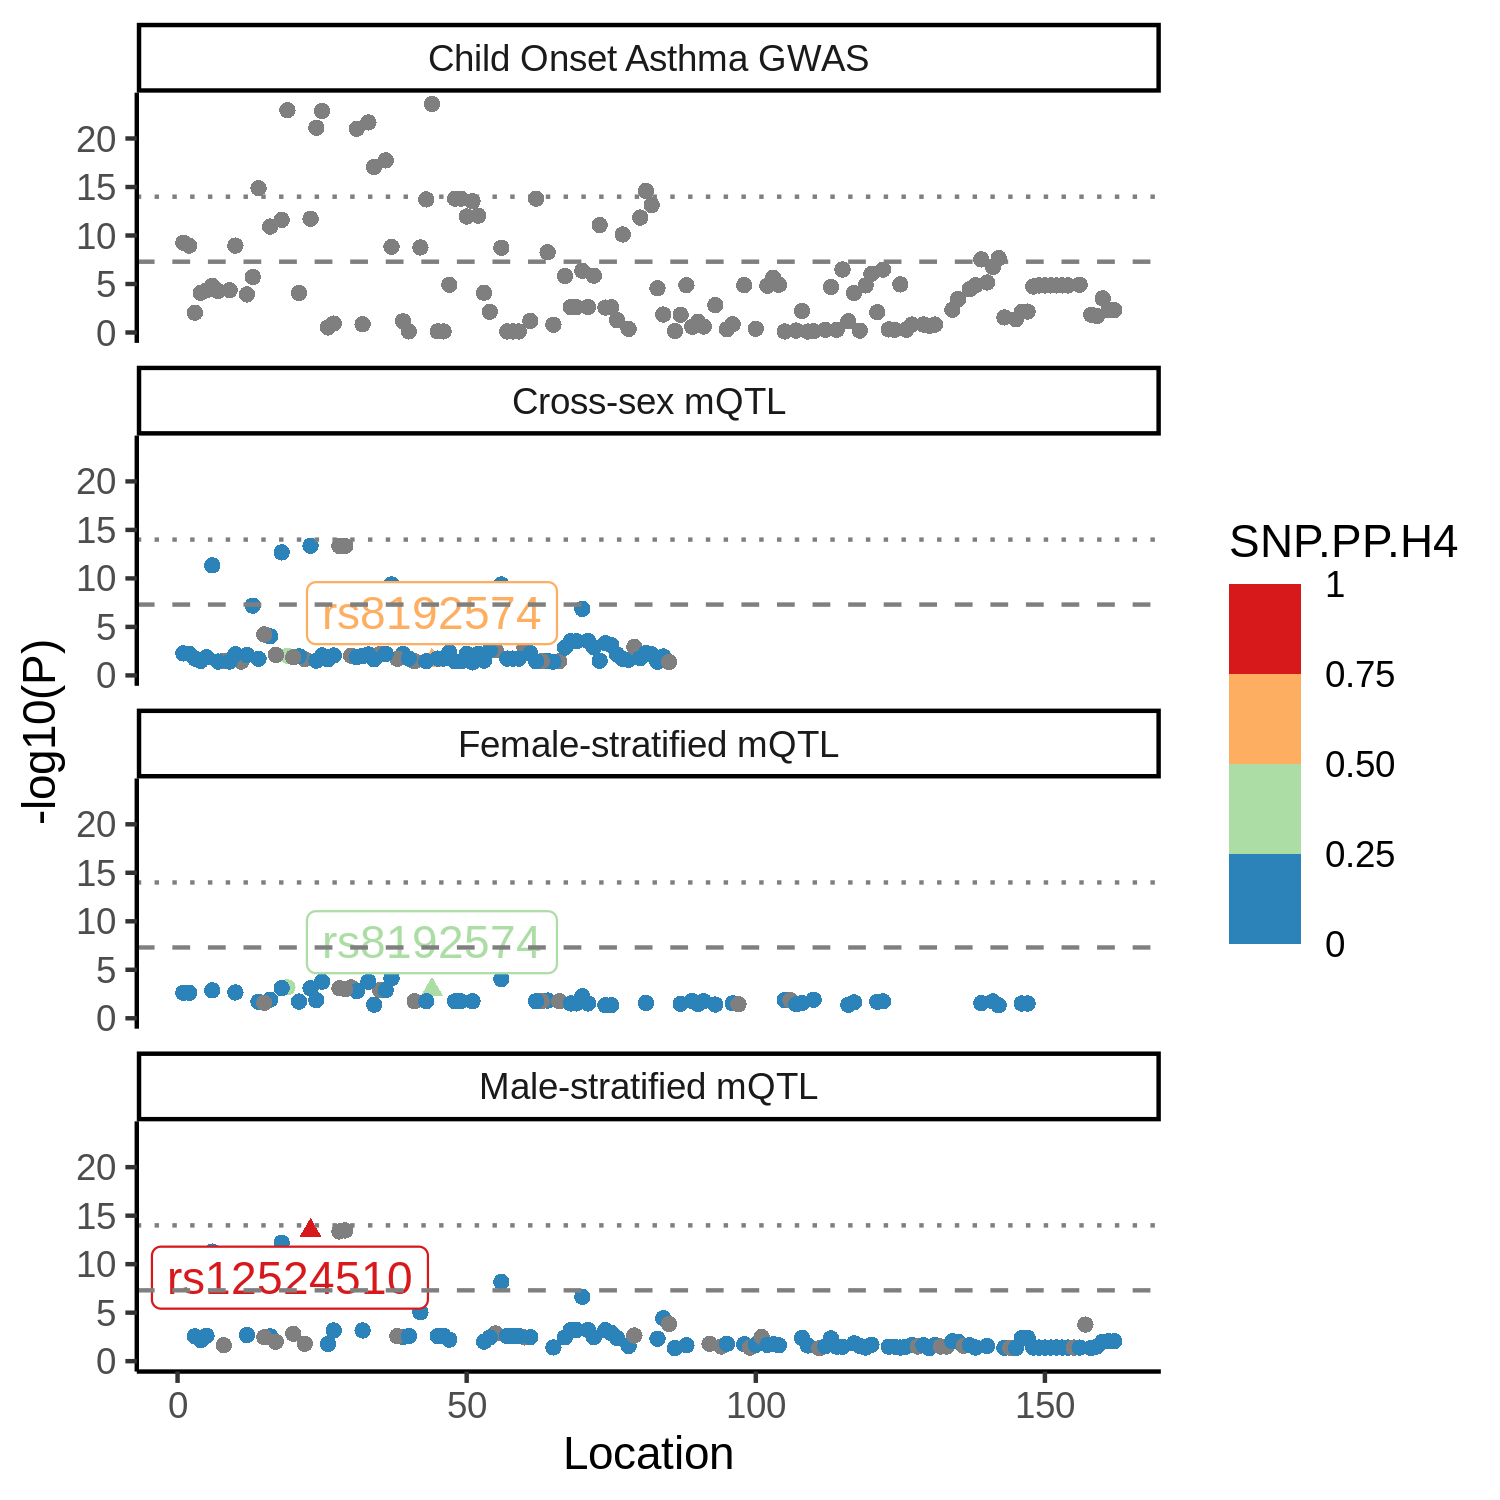

In [27]:
plot_coloc("cg16689962")

Genes for these examples:

In [47]:
manifest[
    V1 %in% c(
        "cg04917860",# Male and Female 
        "cg16689962",# Male Only
        "cg24032190",# Cross-sex Male
        "cg01717973",# Female Only
        "cg19063856",# Cross-sex female
        "cg16796354",# Cross-sex only
        "cg02698622" # Cross-sex, male, and female
    )
]

V1,chr,pos,strand,Name,AddressA,AddressB,ProbeSeqA,ProbeSeqB,Type,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
cg01717973,chr1,151736090,-,cg01717973,20761331,32692366,ATACAACTAAACAAAAATATAAAAAACAAACCAAAAAACAAATAACACCA,ATACGACTAAACGAAAATATAAAAAACGAACCGAAAAACAAATAACACCG,I,⋯,OAZ3;MRPL9,NM_001134939;NM_031420,Body;TSS200,,,NA,1:150002080-150002814,1:151735112-151736753,Promoter_Associated,NA
cg02698622,chr2,242698811,+,cg02698622,29724453,20728346,AAACACCAAAACAACAAACAATACTAAAAATAAAAAACAAATCCATCACA,AAACACCAAAACAACGAACAATACTAAAAATAAAAAACGAATCCATCGCG,I,⋯,D2HGDH,NM_152783,Body,,,NA,2:242347421-242347519,,,NA
cg24032190,chr15,67442893,-,cg24032190,23631447,38808307,CCACCCCCAAACATACAATCTACCCACAAAAAATAATTCATAATACTCCA,CCACCCCCAAACGTACAATCTACCCACAAAAAATAATTCATAATACTCCG,I,⋯,SMAD3;SMAD3;SMAD3,NM_005902;NM_001145103;NM_001145102,Body;Body;5'UTR,,DMR,NA,,,,TRUE
cg16796354,chr3,121726186,+,cg16796354,58663315,NA,AAATTTTCCTCACTCCTTTCTTCCTATATCCCTCTAAAACTACTAAATAC,,II,⋯,ILDR1,NM_175924,Body,,,NA,,,,NA
cg16689962,chr6,32144119,-,cg16689962,19670471,NA,CTCTAACTCCCTTTCAACTCTAAATCCCCTAATACTATATTCCTCCTTCC,,II,⋯,AGPAT1;AGPAT1,NM_006411;NM_032741,TSS1500;5'UTR,,,NA,,6:32143594-32144407,Promoter_Associated,NA
cg04917860,chr7,22757135,-,cg04917860,14759323,NA,TAACRATTATTTCCAAAACATAAATTCCAAAAAAATCCCAACTTTCATTC,,II,⋯,,,,,,TRUE,,,,NA
cg19063856,chr17,38350695,+,cg19063856,43639301,NA,CTACCCCAAAAAACAACTTAACTCACAAACCTAAACATACAAAACAACAC,,II,⋯,RAPGEFL1,NM_016339,3'UTR,,,NA,,17:38350694-38350941,Unclassified,NA
